In [22]:
#format the book
%matplotlib inline
from __future__ import division, print_function
#import matplotlib.pyplot as plt
import book_format
book_format.load_style(name='/custom3.css')

# Kalman Filter

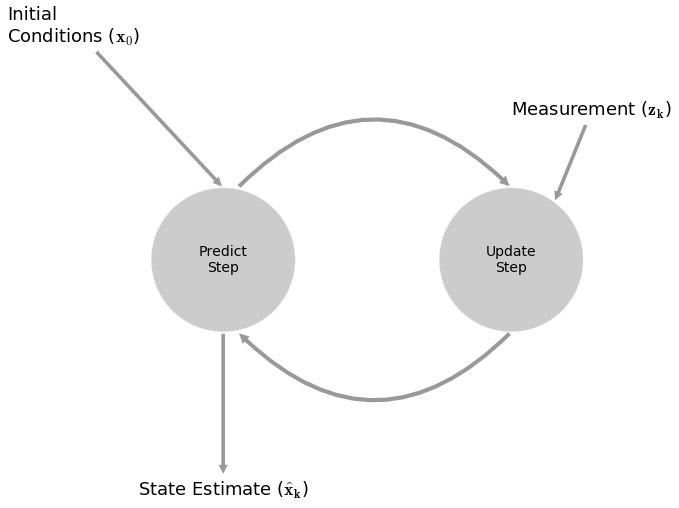

In [23]:
import numpy as np
import pylab as plt
from matplotlib.patches import Circle, Rectangle, Polygon, Arrow, FancyArrow

box_bg = '#CCCCCC'
arrow1 = '#88CCFF'
arrow2 = '#88FF88'

plt.figure(figsize=(6,6), facecolor='w')
ax = plt.axes((0, 0, 1, 1),
              xticks=[], yticks=[], frameon=False)
#ax.set_xlim(0, 10)
#ax.set_ylim(0, 10)


pc = Circle((4,5), 0.5, fc=box_bg)
uc = Circle((6,5), 0.5, fc=box_bg)
ax.add_patch (pc)
ax.add_patch (uc)


plt.text(4,5, "Predict\nStep",ha='center', va='center', fontsize=14)
plt.text(6,5, "Update\nStep",ha='center', va='center', fontsize=14)

#btm
ax.annotate('',
            xy=(4.1, 4.5),  xycoords='data',
            xytext=(6, 4.5), textcoords='data',
            size=20,
            arrowprops=dict(arrowstyle="simple",
                            fc="0.6", ec="none",
                            patchB=pc,
                            patchA=uc,
                            connectionstyle="arc3,rad=-0.5"))
#top
ax.annotate('',
            xy=(6, 5.5),  xycoords='data',
            xytext=(4.1, 5.5), textcoords='data',
            size=20,
            arrowprops=dict(arrowstyle="simple",
                            fc="0.6", ec="none",
                            patchB=uc,
                            patchA=pc,
                            connectionstyle="arc3,rad=-0.5"))


ax.annotate('Measurement ($\mathbf{z_k}$)',
            xy=(6.3, 5.4),  xycoords='data',
            xytext=(6,6), textcoords='data',
            size=18,
            arrowprops=dict(arrowstyle="simple",
                            fc="0.6", ec="none"))

ax.annotate('',
            xy=(4.0, 3.5),  xycoords='data',
            xytext=(4.0,4.5), textcoords='data',
            size=18,
            arrowprops=dict(arrowstyle="simple",
                            fc="0.6", ec="none"))

ax.annotate('Initial\nConditions ($\mathbf{x_0}$)',
            xy=(4.0, 5.5),  xycoords='data',
            xytext=(2.5,6.5), textcoords='data',
            size=18,
            arrowprops=dict(arrowstyle="simple",
                            fc="0.6", ec="none"))

plt.text (4,3.4,'State Estimate ($\mathbf{\hat{x}_k}$)',
          ha='center', va='center', fontsize=18)
plt.axis('equal')
#plt.axis([0,8,0,8])
plt.show()

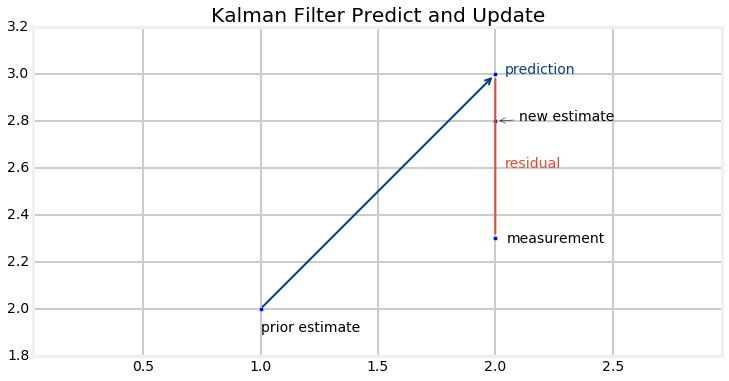

In [24]:
plt.xlim([0.9,2.5])
plt.ylim([1.5,3.5])

plt.scatter ([1,2,2],[2,3,2.3])
plt.scatter ([2],[2.8],marker='o')
ax = plt.axes()
ax.annotate('', xy=(2,3), xytext=(1,2),
            arrowprops=dict(arrowstyle='->', ec='#004080',
                            lw=2,
                            shrinkA=3, shrinkB=4))
ax.annotate('prediction', xy=(2.04,3.), color='#004080')
ax.annotate('measurement', xy=(2.05, 2.28))
ax.annotate('prior estimate', xy=(1, 1.9))
ax.annotate('residual', xy=(2.04,2.6), color='#e24a33')
ax.annotate('new estimate', xy=(2,2.8),xytext=(2.1,2.8),
            arrowprops=dict(arrowstyle='->', ec="k", shrinkA=3, shrinkB=4))
ax.annotate('', xy=(2,3), xytext=(2,2.3),
            arrowprops=dict(arrowstyle="-",
                            ec="#e24a33",
                            lw=2,
                            shrinkA=5, shrinkB=5))
plt.title("Kalman Filter Predict and Update")
plt.axis('equal')
#plt.grid()
plt.show()


In [25]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy.random as random
from numpy import dot

class KalmanFilter:

    def __init__(self, dim_x, dim_z, dim_u=0):
        """ Create a Kalman filter. You are responsible for setting 
        the various state variables to reasonable values; the defaults 
        below will not give you a functional filter.

        **Parameters**

        dim_x : int
            Number of state variables for the Kalman filter. For 
            example, if you are tracking the position and velocity 
            of an object in two dimensions, dim_x would be 4.

            This is used to set the default size of P, Q, and u

        dim_z : int
            Number of of measurement inputs. For example, if the sensor
            provides you with position in (x,y), dim_z would be 2.

        dim_u : int (optional)
            size of the control input, if it is being used.
            Default value of 0 indicates it is not used.
        """

        self.x = np.zeros((dim_x,1)) # state
        self.P = np.eye(dim_x)       # uncertainty covariance
        self.Q = np.eye(dim_x)       # process uncertainty
        self.u = np.zeros((dim_x,1)) # motion vector
        self.B = 0                   # control transition matrix
        self.F = 0                   # state transition matrix
        self.H = 0                   # Measurement function
        self.R = np.eye(dim_z)       # state uncertainty

        # identity matrix. Do not alter this. 
        self._I = np.eye(dim_x)


    def update(self, Z, R=None):
        """
        Add a new measurement (Z) to the kalman filter. If Z is
        None, nothing is changed.

        **Parameters**

        Z : np.array
            measurement for this update.

        R : np.array, scalar, or None
            Optionally provide R to override the measurement noise 
            for this one call, otherwise  self.R will be used.
        """

        if Z is None:
            return

        if R is None:
            R = self.R
        elif np.isscalar(R):
            R = np.eye(self.dim_z) * R

        # error (residual) between measurement and prediction
        y = Z - dot(self.H, self.x)

        # project system uncertainty into measurement space 
        S = dot(self.H, self.P).dot(self.H.T) + R

        # map system uncertainty into kalman gain
        K = dot(self.P, self.H.T).dot(linalg.inv(S))

        # predict new x with residual scaled by the kalman gain
        self.x += dot(K, y)

        I_KH = self._I - dot(K, self.H)
        self.P = I_KH.dot(self.P)


    def predict(self, u=0):
        """ Predict next position.

        **Parameters**

        u : np.array
            Optional control vector. If non-zero, it is multiplied
            by B to create the control input into the system.
        """

        self.x = dot(self.F, self.x) + dot(self.B, u)
        self.P = self.F.dot(self.P).dot(self.F.T) + self.Q

## Tracking a vehicle

Let's go back to our tried problem of tracking our vehicle using *unobserved variables*.

    1. predict the next value for x with "x + vel*time".
    2. adjust covariance for x for uncertainty caused by prediction
    3. get measurement for x
    4. compute residual as: "x - x_prediction"
    5. compute kalman gain based on noise levels
    6. compute new position as "residual * kalman gain"
    7. compute covariance for x to account for additional
       information the measurement provides

### **Step 1:** Choose the State Variables and Set Initial Conditions

* Track both the position and velocity of the vehicle, two state variables.
> This is a design choice with implications and assumptions. For example, we could optionally also track acceleration. The decision to track position and velocity contains an assumption that acceleration is zero, which of course often not true. If the object being tracked *is* accelerating, then the performance of the filter will be suboptimal, or even diverge.

* Position: *observed variables* - directly measured by a sensor.
* Velocity: *unobserved variables* - inferred from the observed variables.

* Use the multivariate Gaussian to specify a position (ex. 1.0 m) and a velocity (ex. 2.3 m/s)

$$\mu = \begin{bmatrix}1.0\\2.3\end{bmatrix}$$

* Use an $n\times 1$ matrix to store  $n$ state variables. For the tracking problem, we use $x$ to denote position, and the first derivative of $x$, $\dot{x}$, for velocity. The Kalman filter equations use $\mathbf{x}$ for the state, which is just the mean of the multivariate Gaussian.

$$\mathbf{x} =\begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

* For the covariance $\Sigma$, the Kalman filter equations use the alternative symbol $\mathbf{P}$.

* Set the initial position to 1.0 m, the initial velocity to 2.3 m/s, the $\sigma^2$ of the position to 500, and the $\sigma^2$ of the velocity to 400.

$$
\begin{aligned}
\mathbf{x} &= \begin{bmatrix}1.0 \\ 2.3\end{bmatrix} \\
\mathbf{P} &= \begin{bmatrix}500 & 0 \\ 0&400\end{bmatrix} \\
\end{aligned}
$$

### **Step 2:** Design the State Transition Function

* This step is telling a Kalman filter how to predict the next state from the current state by providing it with equations that describe the physical model of the system, *process model*, which is described with a set of equations, *State Transition Function*.
* To track a vehicle, we just need to provide it with the Newtonian equations for motion.

$$x_t = \dot{x}_{t-1}\Delta t + x_{t-1}$$

To avoid subscripts, uses $x^-$ to denote the predicted position

$$x^- = \dot{x}\Delta t + x$$

* The $\mathbf{B u}$ term is equal to zero.

$$
\begin{aligned}
\mathbf{x}^- &= \mathbf{Fx} \\
\begin{bmatrix}x \\ \dot{x}\end{bmatrix}^- &= \mathbf{F}\begin{bmatrix}x \\ \dot{x}\end{bmatrix}
\end{aligned}
$$

* The first row of the F is easy to derive:

$$
\begin{aligned}
{\begin{bmatrix}x\\\dot{x}\end{bmatrix}}^- &=\begin{bmatrix}1&\Delta t \\ ?&?\end{bmatrix} \begin{bmatrix}x \\ \dot{x}\end{bmatrix}
\end{aligned}
$$


* Assume that

$$\dot{x}^- = \dot{x}$$

which gives us the second row of $\mathbf{F}$ as follows, once we set $\Delta t = 1$:


$$
{\begin{bmatrix}x\\\dot{x}\end{bmatrix}}^- =\begin{bmatrix}1&1 \\ 0&1\end{bmatrix} \times \begin{bmatrix}x \\ \dot{x}\end{bmatrix}
$$

$$\mathbf{F}=\begin{bmatrix}1&1 \\ 0&1\end{bmatrix}$$ 

### **Step 3:** Design the Measurement Function

* The Kalman filter equation that performs this step is:

$$\textbf{y} = \mathbf{z} - \mathbf{H x^-} \;\;\;(3)$$

where $\textbf{y}$ is the residual, $\mathbf{x^-}$ is the predicted value for $\mathbf{x}$, $\textbf{z}$ is the measurement, and $\textbf{H}$ is the measurement function. It is just a matrix that we multiply the state into to convert it into a measurement.

* For our tracking problem we have a sensor that measures position, but no sensor that measures velocity. 

$$
\begin{aligned}
 \textbf{y} = \mathbf{z} &- \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot{x}\end{bmatrix} \\
\mathbf{H} &= \begin{bmatrix}1&0\end{bmatrix}
\end{aligned}
$$

### **Step 4:** Design the Measurement Noise Matrix

* The *measurement noise matrix* is a matrix that models the noise in our sensors as a covariance matrix, which can be a very difficult thing to do in practice. 

> * A complicated system may have many sensors, the correlation between them might not be clear, and usually their noise is not a pure Gaussian. 
> * For example, a sensor might be biased to read high if the temperature is high, and so the noise is not distributed equally on both sides of the mean. 

* The Kalman filter equations uses the symbol $R$ for this matrix. In general the matrix will have dimension $m{\times}m$, where $m$ is the number of sensors. 

* Only 1 sensor here

$$R = \begin{bmatrix}5\end{bmatrix}$$

### **Step 5:** Design the Process Noise Matrix

* What is *process noise*?

> Consider the motion of a thrown ball. In a vacuum and with constant gravitational force it moves in a parabola. However, if you throw the ball on the surface of the earth you will also need to model factors like rotation and air drag. However, even when you have done all of that there is usually things you cannot account for, such as wind. Without wind sensors, we may have no way to model the wind. The Kalman filter models this as *process noise*, and calls it $\mathbf{Q}$.

* Think of the the underlying system as behaving as

$$f(x) = \mathbf{F}x + w$$

where $\mathbf{F}x$ is the state transition and $w$ is the process noise.

* In 1D tracking we used this code to implement the predict step:

    sigma = sigma + movement_sigma

* We can model the process noise as additional uncertainty.
    
    sigma = sigma + movement_sigma + process_noise

* Use linear algebra to perform this computation. 
      
    P = project_forward(P) + process_noise

where $P$ is the covariance matrix. The Kalman filter equation corresponding to this pseudocode is

$$\mathbf{P} = \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}$$

In this equation $\mathbf{FP{F}}^\mathsf{T}$ projects $\mathbf{P}$ forward to the next time step, and $\mathbf{Q}$ is the *process noise matrix*.

* If we assume that for each time period the acceleration due to process noise is constant and uncorrelated, we get the following.

For constant velocity the form is
 $$\begin{bmatrix}
 \frac{1}{4}{\Delta t}^4 & \frac{1}{2}{\Delta t}^3 \\
 \frac{1}{2}{\Delta t}^3 & \Delta t^2
 \end{bmatrix}\sigma^2
 $$

and for constant acceleration we have

 $$\begin{bmatrix}
 \frac{1}{4}{\Delta t}^4 & \frac{1}{2}{\Delta t}^3 & \frac{1}{2}{\Delta t}^2 \\
 \frac{1}{2}{\Delta t}^3 & {\Delta t}^2 & \Delta t \\
 \frac{1}{2}{\Delta t}^2 & \Delta t & 1
 \end{bmatrix} \sigma^2
 $$

A good choice is to set σ somewhere from 12Δa to Δa, where Δa is the maximum amount that the acceleration will change between sample periods. In practice we pick a number, run simulations on data, and choose a value that works well.

In [26]:
from numpy import array

def Q_discrete_white_noise(dim, dt=1., var=1.):
    assert dim == 2 or dim == 3
    if dim == 2:
        Q = array([[.25*dt**4, .5*dt**3],
                   [ .5*dt**3,    dt**2]], dtype=float)
    else:
        Q = array([[.25*dt**4, .5*dt**3, .5*dt**2],
                   [ .5*dt**3,    dt**2,       dt],
                   [ .5*dt**2,       dt,        1]], dtype=float)

    return Q * var

Q = Q_discrete_white_noise(dim=2, dt=0.1, var=2.35)
Q

array([[ 0.00005875,  0.001175  ],
       [ 0.001175  ,  0.0235    ]])

## Implementing the Kalman Filter

> Kalman filtering and optimal estimation library in Python https://github.com/rlabbe/filterpy

In [27]:
import numpy as np

veh_filter = KalmanFilter(dim_x=2, dim_z=1)
veh_filter.x = np.array([0., 0.])        # state (location and velocity)
veh_filter.F = np.array([[1, 1], [0, 1]])  # state transition matrix
veh_filter.H = np.array([[1, 0]])          # Measurement function
veh_filter.R *= 5                          # measurement noise
veh_filter.Q = Q_discrete_white_noise(2, dt=0.1, var=0.1) # process noise
veh_filter.P *= 500.                       # covariance matrix 

**1**: Assign the initial value for our state. Here we just initialize both the position and velocity to zero. 

**2**: Set $\textbf{F}=\begin{bmatrix}1&1\\0&1\end{bmatrix}$, as in design step 2 above. 

**3**: Set $\textbf{H}=\begin{bmatrix}1&0\end{bmatrix}$, as in design step 3 above.

**4**: Set $\textbf{R} = \begin{bmatrix}5\end{bmatrix}$. $\textbf{R}$ is initialized to the identity matrix, so multiplying by 5 performs this assignment for us.

**5** Use the `Q_discrete_white_noise()` method to set $\mathbf{Q}$'s variance to 0.1.

**5**: $\mathbf{P}$ is initialized to the identity matrix of size $n{\times}n$, so multiplying by 500 assigns a variance of 500 to $x$ and $\dot{x}$. So $\verb,f.P,$ contains

$$\begin{bmatrix} 500&0\\0&500\end{bmatrix}$$

In [28]:
import numpy as np
import numpy.random as random
import math

class VehSensor(object):

    def __init__(self, x0=0, velocity=1, noise_var=0.0):
        """ x0 - initial position
            velocity - (+=right, -=left)
            noise_var - noise variance, 0== no noise
        """
        self.x = x0
        self.velocity = velocity
        self.noise = math.sqrt(noise_var)

    def sense(self):
        self.x = self.x + self.velocity
        return self.x + random.randn() * self.noise

    
def veh_tracking_filter(R, Q=0, cov=1.):
    veh_filter = KalmanFilter(dim_x=2, dim_z=1)
    veh_filter.x = np.array([0., 0.])    # (location and velocity)
    veh_filter.F = np.array([[1, 1],
                             [0, 1]]) # state transition matrix
    veh_filter.H = np.array([[1, 0]]) # Measurement function
    veh_filter.R *= R                 # measurement uncertainty
    veh_filter.P *= cov               # covariance matrix 
    if np.isscalar(Q):
        veh_filter.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=Q)
    else:
        veh_filter.Q = Q
    return veh_filter


def filter_veh(noise_var=0, count=0, R=0, Q=0, P=500., data=None, 
               initial_x=None):
    """ Kalman filter 'count' readings from the VehSensor.
    'noise_var' is the variance of the noise from the measurements.
    'data' provides the measurements. If set, noise will
    be ignored and data will not be generated for you.
    
    returns a tuple of (positions, measurements, covariance)
    """
    if data is None:    
        veh = VehSensor(velocity=1, noise_var=noise_var)
        zs = [veh.sense() for t in range(count)]
    else:
        zs = data

    veh_filter = veh_tracking_filter(R=R, Q=Q, cov=P)
    if initial_x is not None:
        veh_filter.x = initial_x

    pos = [None] * count
    cov = [None] * count
    
    for t in range(count):
        z = zs[t]
        pos[t] = veh_filter.x[0]
        cov[t] = veh_filter.P
    
        # perform the kalman filter steps
        veh_filter.update(z)
        veh_filter.predict()
        
    return (pos, zs, cov)

* Plot the result, starting by filtering 50 measurements with a noise variance of 10 and a process variance of 0.01.

In [29]:
import book_plots as bp

def plot_track(noise_var=None, count=0, R_var=0, Q_var=0, P=500., 
               initial_x=None,data=None, plot_P=True, y_lim=None,
               title='Kalman Filter'):
    
    ps, zs, cov = filter_veh(noise_var=noise_var, data=data, count=count,
                             R=R_var, Q=Q_var, P=P, initial_x=initial_x)
    
    actual = np.linspace(0, count-1, count)
    cov = np.asarray(cov)
    std = np.sqrt(cov[:,0,0])
    #std_top = np.minimum(actual+std, [count+10])
    #std_btm = np.maximum(actual-std, [-50])

    std_top = actual+std
    std_btm = actual-std
    
    bp.plot_track(actual)
    bp.plot_measurements(range(1, count+1), zs)
    bp.plot_filter(range(1, count+1), ps)

    plt.plot(actual+std, linestyle=':', c='k', lw=2)
    plt.plot(actual-std, linestyle=':', c='k', lw=2)
    plt.fill_between(range(count), std_btm, std_top,
                     facecolor='yellow', alpha=0.2)
    plt.legend(loc=4)
    if y_lim is not None:
        plt.ylim(y_lim)
    else:
        plt.ylim((-50, count+10))
        
    plt.xlim((0,count))
    plt.title(title)
    plt.show()
    
    if plot_P:
        ax = plt.subplot(121)
        ax.set_title("$\sigma^2_x$")
        plot_covariance(cov, (0, 0))
        ax = plt.subplot(122)
        ax.set_title("$\sigma^2_y$")
        plot_covariance(cov, (1, 1))      
        plt.show()
    
def plot_covariance(P, index=(0, 0)):
    ps = []
    for p in P:
        ps.append(p[index[0], index[1]])
    plt.plot(ps)

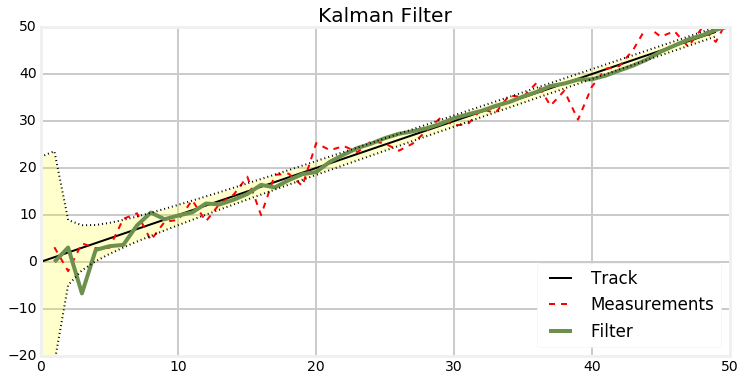

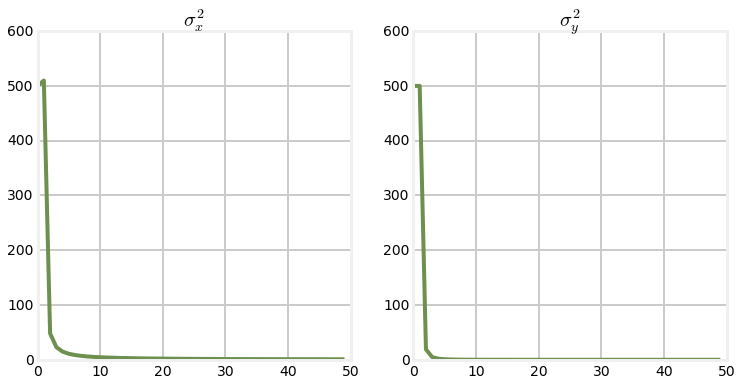

In [30]:
plot_track(noise_var=10, R_var=10., Q_var=0.01, count=50, y_lim=(-20,50))

* The first plot plots the output of the Kalman filter against the measurements and the actual position of the vehicle (drawn in green). 

* After the initial settling in period the filter should track the vehicle's position very closely. 

* The yellow shaded portion between the black dotted lines shows 1 standard deviations of the filter's variance

* The next two plots show the variance of $x$ and of $\dot{x}$, the diagonals of $\mathbf{P}$ over time.  $\mathbf{P}[0,0]$ is the variance of $x$, and $\mathbf{P}[1,1]$ is the variance of $\dot{x}$. 

* Despite initializing $\mathbf{P}=(\begin{smallmatrix}500&0\\0&500\end{smallmatrix})$, the output quickly converges to small variances for both the position and velocity. The covariance matrix $\mathbf{P}$ tells us the *theoretical* performance of the filter *assuming* everything we tell it is true. 

> Recall from the Gaussian chapter that the standard deviation is the square root of the variance, and that approximately 68% of a Gaussian distribution occurs within one standard deviation. Therefore, if at least 68% of the filter output is within one standard deviation we can be sure that the filter is performing well. In the top chart I have displayed the one standard deviation as the yellow shaded area between the two dotted lines. It looks like perhaps the filter is slightly exceeding that bounds, so the filter probably needs some tuning.

## Compare to Univariate Kalman Filter

* Implement a simple 1-D kalman filter using the the univariate Kalman filter, and compare its output to the above kalman filter by plotting it

* Use a simple model of tracking an object that starts at x=0 and moves by 1 at each step. We will assume the arbitrary value 5 for the measurement noise and .02 for the process noise.

Recall that the univariate equations for the update step are:
$$
\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}
\end{aligned}
$$

and that the 1-D equations for the predict step are:
$$
\begin{aligned}
\mu &= \mu_1+\mu_2, \\ \sigma^2 &= \sigma_1^2 + \sigma_2^2
\end{aligned}
$$

In [31]:
# 1-D Kalman filter equations
def predict(pos, variance, movement, movement_variance):
    return (pos + movement, variance + movement_variance)

def update (mu1, var1, mu2, var2):
    mean = (var1*mu2 + var2*mu1) / (var1+var2)
    variance = 1 / (1/var1 + 1/var2)
    return (mean, variance)

In [32]:
def mkf_filter(R, Q):
    f = KalmanFilter(dim_x=1, dim_z=1, dim_u=1)
    f.P = 500.
    f.H = np.array([[1.]])
    f.F = np.array([[1.]])
    f.B = np.array([[1.]])
    f.Q = Q
    f.R = R
    
    return f

* Plot the data from the 1-D Kalman filter as a blue line, and the output of the filter from this chapter as red dots

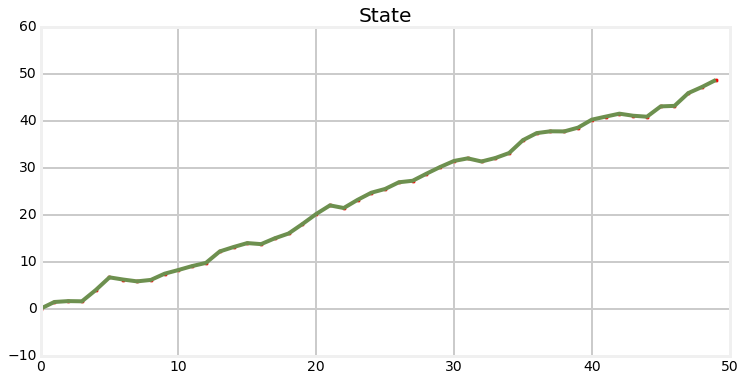

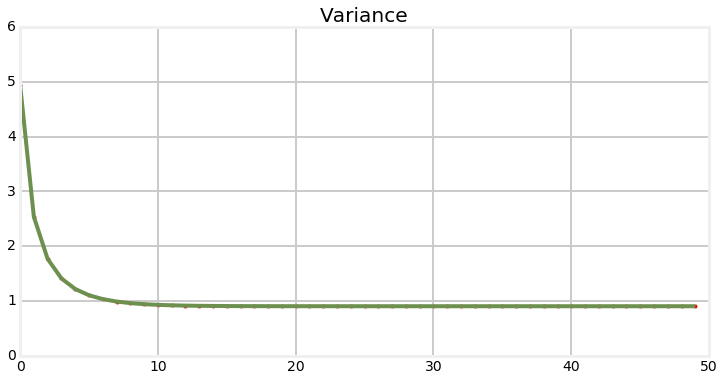

In [33]:
from numpy.random import randn

# Compare by plotting
def plot_kf_compare(x0, p0, R, Q, move):
    # storage for filter output
    x1,x2 = [], []
    p1, p2 = [], []

    # initialize the filters
    f = mkf_filter(R, Q)
    f.x[0] = 0.
    f.P = p0
    pos = (x0, p0)
    for i in range(50):
        z = i*move + randn()
        pos = update(pos[0], pos[1], z, R)
        f.update(z)

        x1.append(pos[0])
        x2.append(f.x[0])

        p1.append(pos[1])
        p2.append(f.P[0, 0])

        u = move + randn()
        pos = predict(pos[0], pos[1], u, Q)
        f.predict(u=u)

    plt.scatter(range(len(x2)), x2, c='r')
    plt.title('State')
    plt.plot(x1)
    plt.xlim([0, 50])

    plt.figure()
    plt.plot(p1)
    plt.scatter(range(len(x2)), p2, c='r')
    plt.title('Variance')
    plt.xlim([0, 50])
    plt.show()
    
plot_kf_compare(x0=0., p0=500., R=5., Q=.2, move=1.)

* Both filters produce the same results. This is a solid demonstration, albeit not a rigorous proof, that both filters in fact implement the same math for the 1-D case. 

## Compare to a Filter That Incorporates Velocity
* Uses the state $\mathbf{x}=\begin{bmatrix}x & \dot{x}\end{bmatrix}^\mathsf{T}$ and compare it against the filter which used the state $\mathbf{x}=\begin{bmatrix}x\end{bmatrix}$.

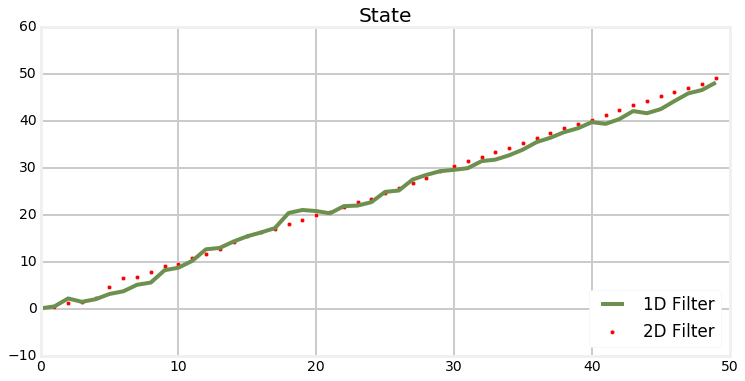

In [34]:
def pos_vel_filter(R,Q):
    f = KalmanFilter(dim_x=2, dim_z=1)
    f.R = R
    f.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=Q)
   
    f.F = np.array([[1, 1],
                    [0, 1]])  # state transition matrix
    f.H = np.array([[1, 0]])  # Measurement function
    return f

def plot_compare_pos_vel(x0, p0, R, Q, move):
    # storage for filter output
    x1, x2 = [], []

    # initialize the filters
    f1 = mkf_filter(R, Q)
    f1.x[0] = 0.
    f1.P = p0
    
    f2 = pos_vel_filter(R, Q)
    f2.x[0] = 0.
    f2.x[1] = 1.
    f2.P *= p0
    
    for i in range(50):
        u = move + randn()
        f1.predict(u=u)
        f2.predict(u=u)
        
        z = i*move + randn()
        f1.update(z)
        f2.update(z)
        
        x1.append(f1.x[0, 0])
        x2.append(f2.x[0, 0])

    plt.plot(x1, label='1D Filter')
    plt.scatter(range(len(x2)), x2, c='r', label='2D Filter')
    plt.title('State')
    plt.legend(loc=4)
    plt.xlim([0,50])
    plt.show()
    
plot_compare_pos_vel(x0=0., p0=500., R=5., Q=.2, move=1.)    

* The output of the filter that incorporates velocity into the state produces much better output than the filter that only tracks position - the output is much closer to a straight line.

## Adjusting the Filter

* It is difficult and often impossible to exactly model our sensors
        It is very normal to vary the parameters to tune Kalman filters so that they perform well with real world sensors.
* Designing a Kalman filter is as much art as science
        The science is, roughly, designing the H and F matrices - they develop in an obvious manner based on the physics of the system we are modeling.
        The art comes in modeling the sensors and selecting appropriate values for the rest of our variables
* Let's look at the effects of the noise parameters R and Q
        Measurements in zs based on a variance of 50 meters magnifies the effects of various design choices on the graphs, making it easier to recognize what is happening. 

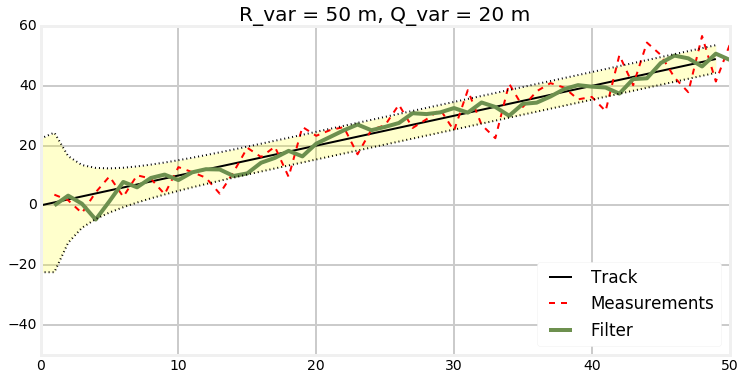

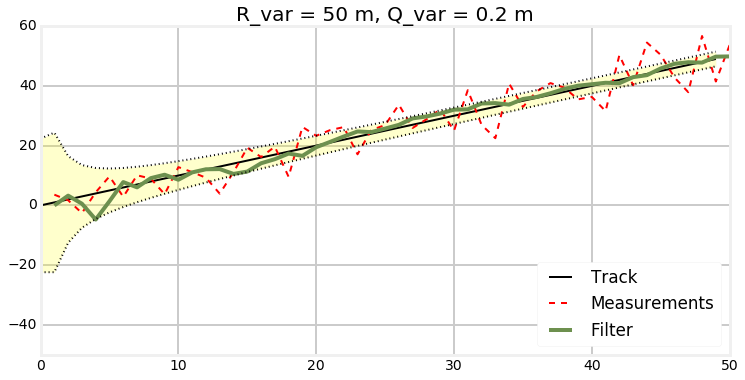

In [35]:
# guarantee the noise is the same each time
# variance of zs = 50 magnifies the effects of design chooices

zs = [3.59, 1.73, -2.575, 4.38, 9.71, 2.88, 10.08, 8.97, 3.74,
      12.81, 11.15, 9.25, 3.93, 11.11, 19.29,  16.20, 19.63,
      9.54, 26.27, 23.29, 25.18, 26.21, 17.1, 25.27, 26.86,
      33.70, 25.92, 28.82, 32.13, 25.0, 38.56, 26.97, 22.49,
      40.77, 32.95, 38.20, 40.93, 39.42, 35.49, 36.31, 31.56,
      50.29, 40.20, 54.49, 50.38, 42.79, 37.89, 56.69, 41.47, 53.66]
    
plot_track(data=zs, R_var=50, Q_var=20, count=50, plot_P=False, 
           title='R_var = 50 m, Q_var = 20 m')

plot_track(data=zs, R_var=50, Q_var=.2, count=50, plot_P=False, 
           title='R_var = 50 m, Q_var = 0.2 m')

* The filter in the first plot follows the noisy measurement almost exactly
* The filter in the second plot varies from the measurement quite a bit, and is much closer to a straight line than in the first graph

        In the first case we set Q_var=20 m, which is quite large. In physical terms this is telling the filter "I don't trust my motion prediction step".  So the filter will be computing velocity (x˙), but then mostly ignoring it because we are telling the filter that the computation is extremely suspect. Therefore the filter has nothing to use but the measurements, and thus it follows the measurements closely.

        In the second case we set Q_var=0.02 m, which is quite small. In physical terms we are telling the filter "trust the motion computation, it is really good!". So the filter ends up ignoring some of the measurement as it jumps up and down, because the variation in the measurement does not match our trustworthy velocity prediction.

* Set Q_var=0.2 m, and bump R_var up to 10,000 m. This is telling the filter that the measurement noise is very large. 

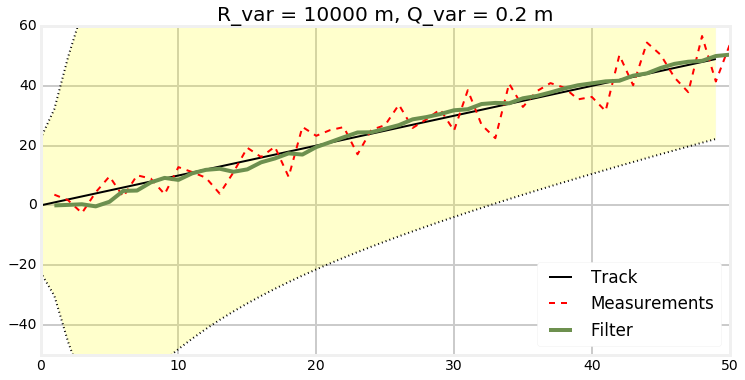

In [36]:
plot_track(data=zs, R_var=10000., Q_var=.2, count=50, plot_P=False, 
           title='R_var = 10000 m, Q_var = 0.2 m')

* By setting the filter's noise variance so high we force the filter to favor the prediction over the measurement, leading to apparently very smooth and good looking results.

* Let's see the result of a bad initial guess for the position by guessing the initial position to be 20 m and the initial velocity to be 1 m/s.

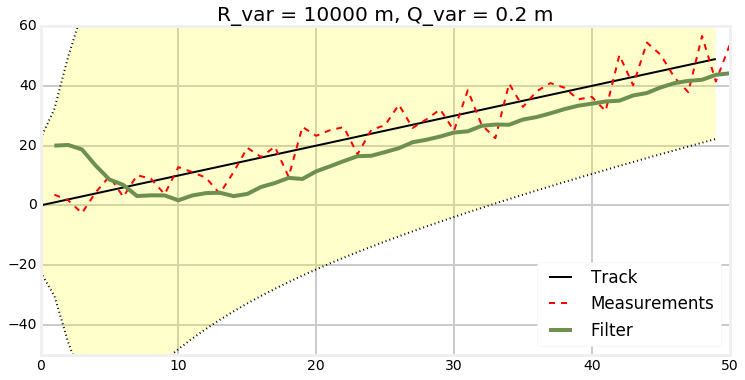

In [37]:
plot_track(data=zs, R_var=10000., Q_var=.2, count=50, 
           initial_x=np.array([20., 1.]), plot_P=False, 
           title='R_var = 10000 m, Q_var = 0.2 m')

The filter cannot acquire the actual track at all, because even though the filter is getting reasonable good measurements it assumes that the measurements are bad, and eventually just predicts forward from a bad position at each step. 

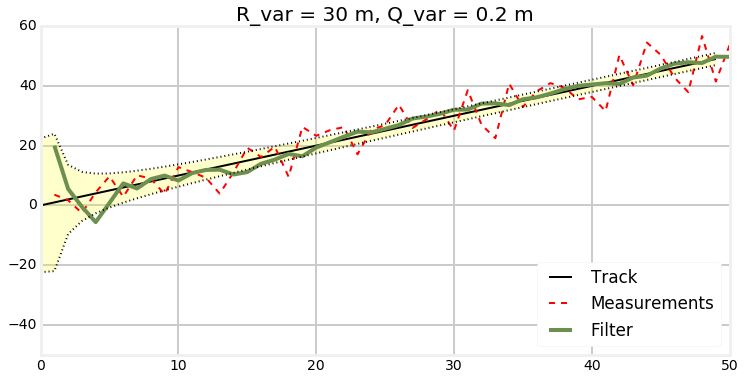

In [38]:
plot_track(data=zs, R_var=30, Q_var=.2, count=50, 
           initial_x=np.array([20., 1.]), plot_P=False, 
           title='R_var = 30 m, Q_var = 0.2 m')

The filter initially struggles for several iterations to acquire the track, but then it accurately tracks the car

To some extent you can get similar looking output by varying either R or Q, but always think about the physical implications of these assignments, and vary R and/or Q based on your knowledge of the system you are filtering.

## Examination of the Covariance Matrix

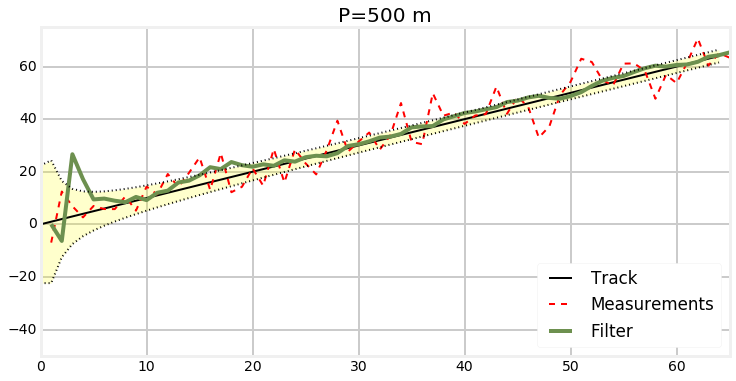

In [39]:
# guarantee the noise is the same each time
zs = [-6.947, 12.467, 6.899, 2.643, 6.980, 5.820, 5.788, 10.614, 5.210, 
      14.338, 11.401, 19.138, 14.169, 19.572, 25.471, 13.099, 27.090,
      12.209, 14.274, 21.302, 14.678, 28.655, 15.914, 28.506, 23.181, 
      18.981, 28.197, 39.412, 27.640, 31.465, 34.903, 28.420, 33.889, 
      46.123, 31.355, 30.473, 49.861, 41.310, 42.526, 38.183, 41.383, 
      41.919, 52.372, 42.048, 48.522, 44.681, 32.989, 37.288, 49.141, 
      54.235, 62.974, 61.742, 54.863, 52.831, 61.122, 61.187, 58.441, 
      47.769, 56.855, 53.693, 61.534, 70.665, 60.355, 65.095, 63.386]

plot_track(data=zs, R_var=50., Q_var=.2, P=500., count=len(zs), 
           plot_P=False, title='P=500 m')

Looking at the output we see a very large spike in the filter output at the beginning. If you look at the data (dotted red line) you will see a corresponding, smaller spike in the beginning of the data. We set `P=500 m`, which corresponds to $\text{P}=[\begin{smallmatrix}500&0\\0&500\end{smallmatrix}]$. We now have enough information to understand what this means, and how the Kalman filter treats it. The 500 in the upper left hand corner corresponds to $\sigma^2_x$; therefore we are saying the standard deviation of `x` is $\sqrt{500}$, or roughly 22.36 m. If we recall how standard deviations work, roughly 99% of the samples occur withing $3\sigma$, therefore `P=500` is telling the Kalman filter that the initial estimate could be up to 67 meters off. That is a pretty large error, so when the measurement spikes the Kalman filter distrusts its own estimate and jumps wildly to try to incorporate the measurement. Then, as the filter evolves $\mathbf{P}$ quickly converges to a more realistic value.

Now let us see the effect of a smaller initial value for `P`.

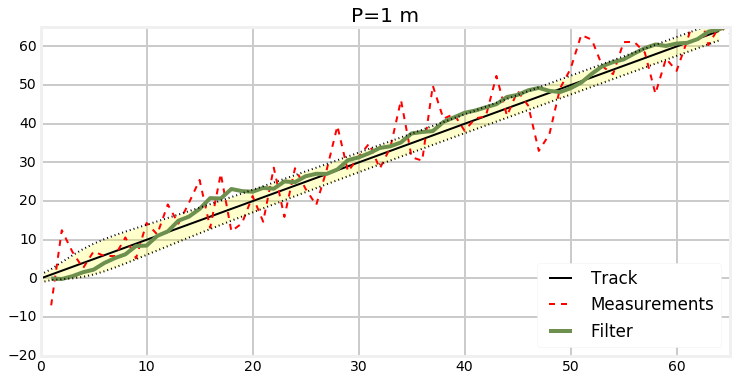

In [40]:
plot_track(data=zs, R_var=50., Q_var=.2, P=1., count=len(zs), 
           y_lim=(-20,65), plot_P=False, title='P=1 m')

* This *looks* fantastic at first blush. The plot does not have the spike that the former plot did; the filter starts tracking the measurements and doesn't take any time to settle to the signal. 
* However, there is an initial spike for the variance in position, and that it never really converges.
* Using a small $\text{P}$ will avoid having the Kalman filter take time to accurately track the signal, but if we are truly uncertain about the initial measurements this can cause the filter to generate very bad results.
* For your Kalman filter to perform well you must set $\text{P}$ to a value that truly reflects your knowledge about the data. 

Let's see the result of a bad initial estimate coupled with a very small $\text{P}$ We will set our initial estimate at 100m (whereas the dog starts at 0m), but set `P=1 m`.

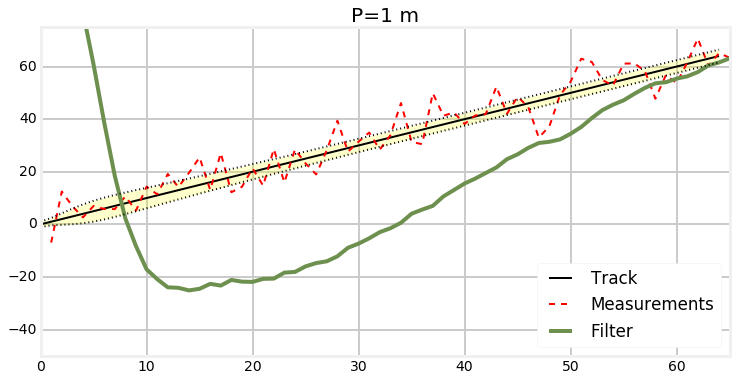

In [41]:
x = np.array([100., 0.]).T
plot_track(data=zs, R_var=50., Q_var=.2, P=1., initial_x=x,
           count=len(zs), plot_P=False, title='P=1 m')

* The initial estimates are terrible and that it takes the filter a long time to start converging onto the signal
* This is because we told the Kalman filter that we strongly believe in our initial estimate of 100m and were incorrect in that belief.

Now, let's provide a more reasonable value for P and see the difference.

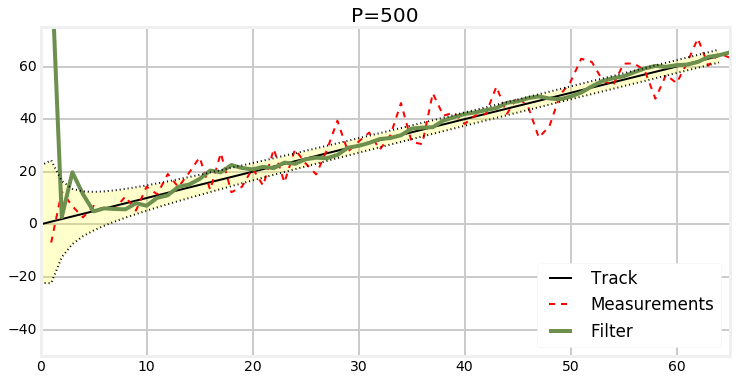

In [42]:
x = np.array([100., 0]).T
plot_track(data=zs, R_var=50., Q_var=.2, P=500., initial_x=x,
           count=len(zs), plot_P=False, title='P=500')


* The Kalman filter is very uncertain about the initial state, so it converges onto the signal much faster. It is producing good output after only 5 to 6 evolutions. 
* If we do not know where the object is when we start tracking, we would normally take the first measurement, use that to initialize the Kalman filter, and proceed from there.

Lets plot the covariance ellipses on the same plot as the position.

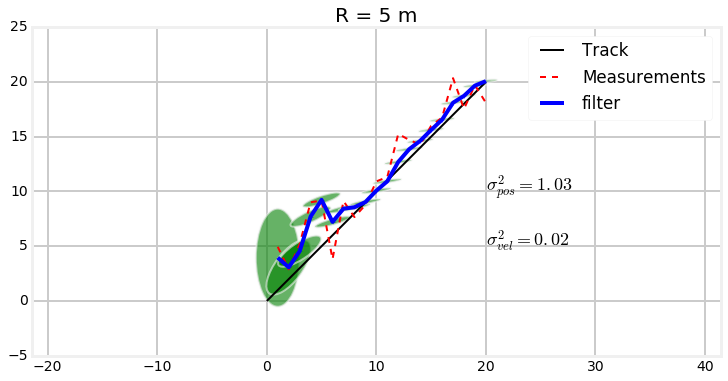

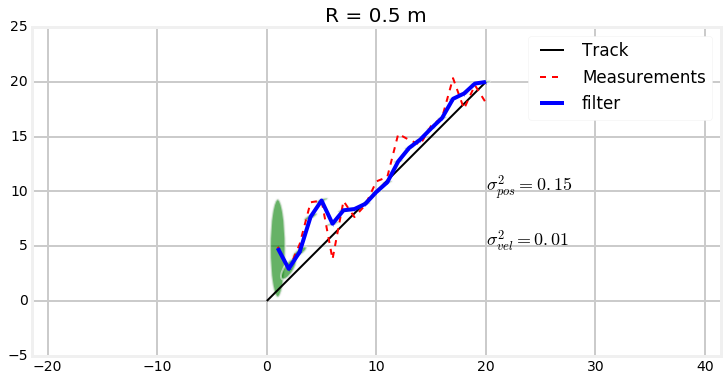

In [43]:
import stats

def plot_track_ellipses(noise, count, R, Q=0, P=20., plot_P=True, 
                        title='Kalman Filter'):
    veh = VehSensor(velocity=1, noise_var=noise)
    f = veh_tracking_filter(R=R, Q=Q, cov=P)

    ps = []
    zs = []
    cov = []
    for t in range (count):
        z = veh.sense()
        f.update(z)
        ps.append(f.x[0])
        cov.append(f.P)
        zs.append(z)
        f.predict()

    bp.plot_track([0, count], [0, count])
    bp.plot_measurements(range(1,count+1), zs)
    plt.plot(range(1,count+1), ps, c='b', label='filter')
    plt.legend(loc='best')
    plt.title(title)

    for i,p in enumerate(cov):
        stats.plot_covariance_ellipse(
              (i+1, ps[i]), cov=p, axis_equal=False, 
               facecolor='g', edgecolor=None, alpha=0.6)

        if i == len(cov)-1:
            s = ('$\sigma^2_{pos} = %.2f$' % p[0,0])
            plt.text (20, 10, s, fontsize=18)
            s = ('$\sigma^2_{vel} = %.2f$' % p[1,1])
            plt.text (20, 5, s, fontsize=18)
    plt.axis('equal')
    plt.show()

np.random.seed(0)
plot_track_ellipses(noise=5, R=5., Q=.2, count=20, title='R = 5 m')
np.random.seed(0)
plot_track_ellipses(noise=5, R=.5, Q=.2, count=20, title='R = 0.5 m')

Here is an animation of the filter filtering the data. The filter parameters have been tuned so that it is easy to see a change in $\mathbf{P}$ as the filter progresses.
<img src='multivariate_track1.gif'>

* We start with the covariance $\mathbf{P}=(\begin{smallmatrix}50&0\\0&50\end{smallmatrix})$, which signifies a lot of uncertainty about our initial belief. 
* After we receive the first measurement the Kalman filter updates this belief, and so the variance is no longer as large. 
* As the filter continues processing the measurements the covariance ellipse quickly shifts shape until it settles down to being a long, narrow ellipse tilted in the direction of movement.
* The x-axis of the ellipse denotes our uncertainty in position, and the y-axis our uncertainty in velocity. So, an ellipse that is taller than it is wide signifies that we are more uncertain about the velocity than the position. Conversely, a wide, narrow ellipse shows high uncertainty in position and low uncertainty in velocity. Finally, the amount of tilt shows the amount of correlation between the two variables. 

* The ellipses in the second plot are all much smaller than the ellipses in the first plot. This stands to reason because a small $\small\mathbf{R}$ implies a small amount of noise in our measurements. Small noise means accurate predictions. 

## Tracking a vehicle in a 2D space

* A very simple sensor, one that travels in a straight line.
* It takes as input the last position, velocity, and how much noise we want, and returns the new position. 

In [25]:
import numpy.random as random
import copy
class PosSensor1(object):
    def __init__(self, pos = [0,0], vel = (0,0), noise_scale = 1.):
        self.vel = vel
        self.noise_scale = noise_scale
        self.pos = copy.deepcopy(pos)
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + random.randn() * self.noise_scale,
                self.pos[1] + random.randn() * self.noise_scale]

### Step 1: Choose the State Variables

* We are tracking in two dimensions and have a sensor that gives us a reading in each of those two dimensions, so we know that we have the two observed variables x and y. 
* If we created our Kalman filter using only those two variables the performance would not be very good because we would be ignoring the information velocity can provide to us. We will want to incorporate velocity into our equations as well.

$$\mathbf{x} = 
\begin{bmatrix}x\\v_x\\y\\v_y\end{bmatrix}$$


### **Step 2:** Design State Transition Function

Similar to the 1-D case, the state equations for position and velocity would be:

$$
\begin{aligned}
x' &= (1*x) + (\Delta t * v_x) + (0*y) + (0 * v_y) \\
v_x &= (0*x) +  (1*v_x) + (0*y) + (0 * v_y) \\
y' &= (0*x) + (0* v_x)         + (1*y) + (\Delta t * v_y) \\
v_y &= (0*x) +  (0*v_x) + (0*y) + (1 * v_y)
\end{aligned}
$$

In linear algebra, we would write this as:

$$
\begin{bmatrix}x\\v_x\\y\\v_y\end{bmatrix}' = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix}\begin{bmatrix}x\\v_x\\y\\v_y\end{bmatrix}$$

In [26]:
import numpy as np

tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 1.   # time step

tracker.F = np.array ([[1, dt, 0,  0],
                      [0,  1, 0,  0],
                      [0,  0, 1, dt],
                      [0,  0, 0,  1]])

### **Step 3**: Design the Motion Function

We have no control inputs to our vehicle, so set the motion input $\small\mathbf{u}$ to zero.

In [27]:
tracker.u = 0.

### **Step 4**: Design the Measurement Function

* The measurement function defines how we go from the state variables to the measurements using the equation $\mathbf{z} = \mathbf{Hx}$. 
* $\textbf{z}$ is of dimension $2\times 1$ since we have measurements for (x,y). Our state variable is size $4\times 1$. We can deduce the required size for $\textbf{H}$ by recalling that multiplying a matrix of size $m\times n$ by $n\times p$ yields a matrix of size $m\times p$. Thus,

$$ 
\begin{aligned}
(2\times 1) &= (a\times b)(4 \times 1) \\
&= (a\times 4)(4\times 1) \\
&= (2\times 4)(4\times 1)
\end{aligned}$$

So, $\textbf{H}$ is of size $2\times 4$.

* Filling in the values for $\textbf{H}$ is easy but let's make this just slightly more interesting by deciding we want to change units. So we will assume that the measurements are returned in feet, and that we desire to work in meters. Converting from feet to meters is a simple as multiplying by 0.3048. However, we are converting from state (meters) to measurements (feet) so we need to divide by 0.3048. 

$$
\begin{aligned}
z_x' &= (\frac{x}{0.3048}) + (0* v_x) + (0*y) + (0 * v_y) \\
z_y' &= (0*x) + (0* v_x) + (\frac{y}{0.3048}) + (0 * v_y) \\
\end{aligned}
$$

$$\mathbf{H} =
\begin{bmatrix} 
\frac{1}{0.3048} & 0 & 0 & 0 \\
0 & 0 & \frac{1}{0.3048} & 0
\end{bmatrix}
$$

In [28]:
tracker.H = np.array([[1/0.3048, 0, 0, 0],
                      [0, 0, 1/0.3048, 0]])
print(tracker.H)

[[ 3.2808399  0.         0.         0.       ]
 [ 0.         0.         3.2808399  0.       ]]


### **Step 5**: Design the Measurement Noise Matrix

* Make the simple assumption that the $x$ and $y$ variables are independent Gaussian processes, so there is no covariance.

$$\mathbf{R} = \begin{bmatrix}5&0\\0&5\end{bmatrix}$$


In [29]:
tracker.R = np.array([[5, 0],
                      [0, 5]])
print(tracker.R)

[[5 0]
 [0 5]]


### Step 6: Design the Process Noise Matrix

* Assume there is a small amount of process noise, say 0.1 for each state variable. 
* We have 4 state variables, so we need a $4{\times}4$ covariance matrix:

$$\mathbf{Q} = \begin{bmatrix}0.1&0&0&0\\0&0.1&0&0\\0&0&0.1&0\\0&0&0&0.1\end{bmatrix}$$


In [30]:
tracker.Q = np.eye(4) * 0.1
print(tracker.Q)

[[ 0.1  0.   0.   0. ]
 [ 0.   0.1  0.   0. ]
 [ 0.   0.   0.1  0. ]
 [ 0.   0.   0.   0.1]]


### **Step 7**: Design Initial Conditions

For our simple problem we will set the initial position at (0,0) with a velocity of (0,0). Since that is a pure guess, we will set the covariance matrix $\small\mathbf{P}$ to a large value.
$$ \mathbf{x} = \begin{bmatrix}0\\0\\0\\0\end{bmatrix}\\
\mathbf{P} = \begin{bmatrix}500&0&0&0\\0&500&0&0\\0&0&500&0\\0&0&0&500\end{bmatrix}$$


In [31]:
tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500.
print(tracker.x)
print()
print (tracker.P)

[[0]
 [0]
 [0]
 [0]]

[[ 500.    0.    0.    0.]
 [   0.  500.    0.    0.]
 [   0.    0.  500.    0.]
 [   0.    0.    0.  500.]]


## Implement the Filter Code

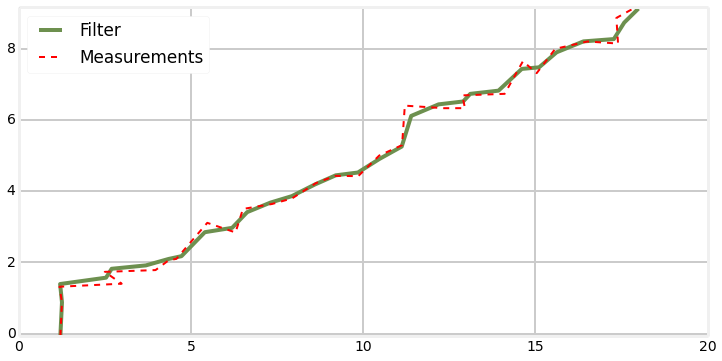

In [32]:
tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 1.0   # time step

tracker.F = np.array ([[1, dt, 0,  0],
                       [0,  1, 0,  0],
                       [0,  0, 1, dt],
                       [0,  0, 0,  1]])
tracker.u = 0.
tracker.H = np.array ([[1/0.3048, 0, 0, 0],
                       [0, 0, 1/0.3048, 0]])

tracker.R = np.eye(2) * 5
tracker.Q = np.eye(4) * .1

tracker.x = np.array([[0,0,0,0]]).T
tracker.P = np.eye(4) * 500.

# initialize storage and other variables for the run
count = 30
xs, ys = [],[]
pxs, pys = [],[]

sensor = PosSensor1 ([0,0], (2,1), 1.)

for i in range(count):
    pos = sensor.read()
    z = np.array([[pos[0]], [pos[1]]])

    tracker.predict ()
    tracker.update (z)

    xs.append (tracker.x[0,0])
    ys.append (tracker.x[2,0])
    pxs.append (pos[0]*.3048)
    pys.append(pos[1]*.3048)

bp.plot_filter(xs, ys)
bp.plot_measurements(pxs, pys)
plt.legend(loc=2)
plt.xlim((0,20))
plt.show()

Run the same Kalman filter with the same settings, but also plot the covariance ellipse for $x$ and $y$

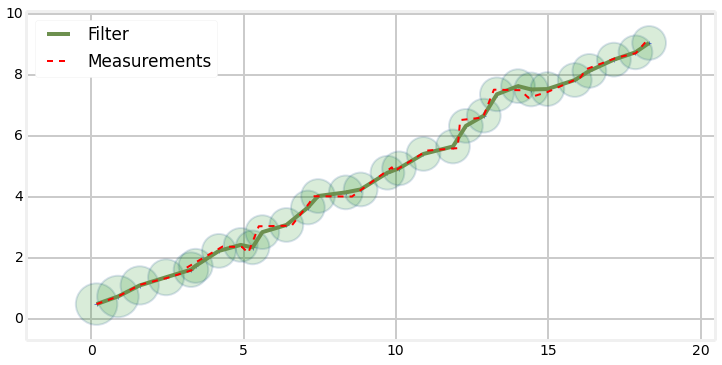

final P is:
[[ 0.30660483  0.12566239  0.          0.        ]
 [ 0.12566239  0.24399092  0.          0.        ]
 [ 0.          0.          0.30660483  0.12566239]
 [ 0.          0.          0.12566239  0.24399092]]


In [33]:
import stats

tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 1.0   # time step

tracker.F = np.array([[1, dt, 0,  0],
                      [0,  1, 0,  0],
                      [0,  0, 1, dt],
                      [0,  0, 0,  1]])
tracker.u = 0.
tracker.H = np.array([[1/0.3048, 0, 0, 0],
                      [0, 0, 1/0.3048, 0]])

tracker.R = np.eye(2) * 5
tracker.Q = np.eye(4) * .1

tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500.

# initialize storage and other variables for the run
count = 30
xs, ys = [], []
pxs, pys = [], []

sensor = PosSensor1([0,0], (2,1), 1.)

for i in range(count):
    pos = sensor.read()
    z = np.array([[pos[0]], [pos[1]]])

    tracker.predict()
    tracker.update(z)

    xs.append(tracker.x[0,0])
    ys.append(tracker.x[2,0])
    pxs.append(pos[0]*.3048)
    pys.append(pos[1]*.3048)

    # plot covariance of x and y
    cov = np.array([[tracker.P[0,0], tracker.P[2,0]], 
                    [tracker.P[0,2], tracker.P[2,2]]])
 
    stats.plot_covariance_ellipse(
        (tracker.x[0,0], tracker.x[2,0]), cov=cov,
         facecolor='g', alpha=0.15)

        
bp.plot_filter(xs, ys)
bp.plot_measurements(pxs, pys)
plt.legend(loc=2)
plt.show()
print("final P is:")
print(tracker.P)

$x$ is not correlated or dependent on $y$. Therefore our ellipses are not tilted. Furthermore, the noise for both $x$ and $y$ are modeled to have the same value, 5, in $\mathbf{R}$. If we were to set R to, for example,

$$\mathbf{R} = \begin{bmatrix}10&0\\0&5\end{bmatrix}$$

we would be telling the Kalman filter that there is more noise in $x$ than $y$, and our ellipses would be longer than they are tall.

The upper left hand side of P shows the covariance of $x$ to $\dot{x}$

[[ 0.30660483  0.12566239]
 [ 0.12566239  0.24399092]]


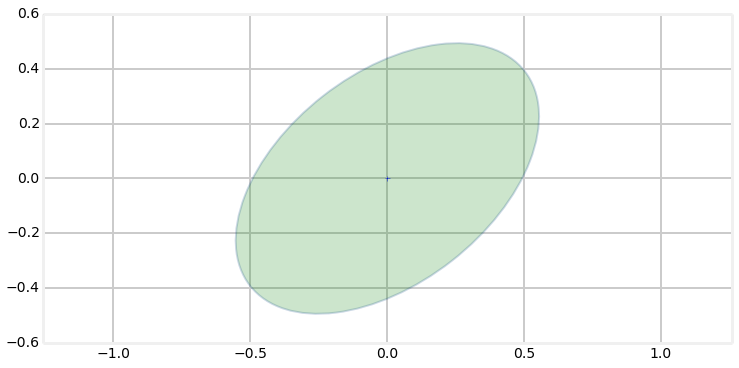

In [34]:
c = tracker.P[0:2, 0:2]
print(c)
stats.plot_covariance_ellipse((0, 0), cov=c, facecolor='g', alpha=0.2)
plt.grid()

## The Effect of Order

* "Order" is the number of derivatives required to accurately model a system. When we design the state variables and process model we must choose the order of the system we want to model. 

* Consider a system that does not change, such as the height of a building. 

There is no change, so there is no need for a derivative, and the order of the system is zero. We could express this in an equation as

$$x = 312.5$$

* A first order system has a first derivative. This is also called a *constant velocity* model

For example, change of position is velocity.

$$ v = \frac{dx}{dt}$$

which we integrate into the Newton equation
$$ x = vt + x_0.$$

* A second order has a second derivative. The second derivative of position is acceleration, with the equation

$$a = \frac{d^2x}{dt^2}$$

which we integrate into 

$$ x = \frac{1}{2}at^2 +v_0t + x_0.$$

This is also known as a *constant acceleration* model.


### Constant velocity system with slight variations

* Let's say we are tracking something with a constant velocity. No real world process is perfect, and so there will be slight variations in the velocity over short time period. 
* Is the best approach to use a second order filter, allowing the acceleration term to deal with the slight variations in velocity?

First simulate on object with a constant velocity, on each update alter the velocity by a small amount, since no physical system has a truly constant velocity

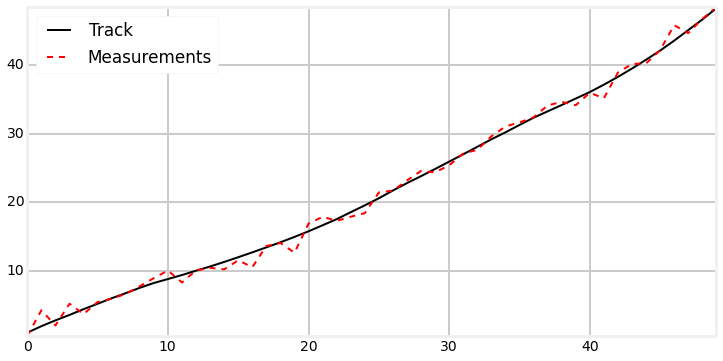

In [35]:
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
import book_plots as bp

np.random.seed(124)
class ConstantVelocityObject(object):
    def __init__(self, x0=0, vel=1., noise_scale=0.06):
        self.x = x0
        self.vel = vel
        self.noise_scale = noise_scale


    def update(self):
        self.vel += randn()*self.noise_scale
        self.x += self.vel
        return (self.x, self.vel)


def sense(x, noise_scale=1.):
    return x[0] + randn()*noise_scale


obj = ConstantVelocityObject()

xs = []
zs = []
for i in range(50):
    x = obj.update()
    z = sense(x)
    xs.append(x)
    zs.append(z)


xs = np.asarray(xs)
bp.plot_track(xs[:,0])
bp.plot_measurements(range(50), zs)
plt.legend(loc='best')
plt.show()

### Zero Order Kalman Filter

In [36]:
def ZeroOrderKF(R, Q):
    """ Create zero order Kalman filter. Specify R and Q as floats."""
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([0.])
    kf.R *= R
    kf.Q *= Q
    kf.P *= 20
    kf.F = np.array([[1.]])
    kf.H = np.array([[1.]])
    return kf

### First Order Kalman Filter

In [37]:
def FirstOrderKF(R, Q, dt):
    """ Create first order Kalman filter. Specify R and Q as floats."""
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.zeros(2)
    kf.P *= np.array([[100,0], [0,1]])
    kf.R *= R
    kf.Q = Q_discrete_white_noise(2, dt, Q)
    kf.F = np.array([[1., dt],
                     [0. , 1]])
    kf.H = np.array([[1., 0]])
    return kf

### Second Order Kalman Filter

* A second order Kalman filter tracks a second order system, such as position, velocity and acceleration. The state variables could be

$$ \mathbf{x} = \begin{bmatrix}x\\\dot{x}\\\ddot{x}\end{bmatrix}$$
 

* The state transition can be obtained from the Newtonian equations for a time step:

$$\begin{aligned} x_t &= x_{t-1} + v_{t-1}\Delta t + 0.5a_{t-1} \Delta t^2 \\
 v_t &= v_{t-1} + a_{t-1} \Delta t \\
 a_t &= a_{t-1}\end{aligned}$$
 
$$\begin{bmatrix}x\\\dot{x}\\\ddot{x}\end{bmatrix} = \mathbf{F}\begin{bmatrix}x\\\dot{x}\\\ddot{x}\end{bmatrix}$$

$$\mathbf{F} = \begin{bmatrix}1 & \Delta t &.5\Delta t^2\\ 
0 & 1 & \Delta t \\
0 & 0 & 1\end{bmatrix}$$

* The measurement function needs to implement

$$z = \mathbf{Hx}$$

Our sensor still only reads position, so it should take the position from the state, and 0 out the velocity, like so:

$$\mathbf{H} = \begin{bmatrix}1 & 0 & 0\end{bmatrix}$$


In [38]:
def SecondOrderKF(R_std, Q, dt):
    """ Create second order Kalman filter. Specify R and Q as floats."""
    kf = KalmanFilter(dim_x=3, dim_z=1)
    kf.x = np.zeros(3)
    kf.P[0,0] = 100
    kf.P[1,1] = 1
    kf.P[2,2] = 1
    kf.R *= R_std**2
    kf.Q = Q_discrete_white_noise(3, dt, Q)
    kf.F = np.array([[1., dt, .5*dt*dt],
                     [0., 1.,       dt],
                     [0., 0.,       1.]])
    kf.H = np.array([[1., 0., 0.]])
    return kf

### Evaluating the Performance

* Plot the track and the Kalman filter output and eyeball the results. 
* **Plot the residuals between the estimated state and actual state and compare them to the standard deviations which we derive from $\mathbf{P}$. If the filter is performing correctly 99% of the residuals will fall within the third standard deviation.**

First, write a routine to generate the noisy measurements.

In [39]:
def simulate_system(Q, count):
    obj = ConstantVelocityObject(x0=0, vel=1, noise_scale=Q)
    zs = []
    xs = []
    for i in range(count):
        x = obj.update()
        z = sense(x)
        xs.append(x)
        zs.append(z)
    return np.asarray(xs), zs

And now a routine to perform the filtering.

In [40]:
def filter_data(kf, zs):
    # save output for plotting
    fxs = []
    ps = []

    for z in zs:
        kf.predict()
        kf.update(z)

        fxs.append(kf.x)
        ps.append(kf.P.diagonal())

    fxs = np.asarray(fxs)
    ps = np.asarray(ps)
    
    return fxs, ps

And to plot the track results.

In [41]:
def plot_kf_output(xs, filter_xs, zs, title=None):
    bp.plot_filter(filter_xs[:,0])
    bp.plot_track(xs[:,0])
    
    if zs is not None:
        bp.plot_measurements(zs)
    plt.legend(loc='best')
    plt.ylabel('meters')
    plt.xlabel('time (sec)')
    if title is not None:
        plt.title(title)
    plt.xlim((-1, len(xs)))
    plt.ylim((-1, len(xs)))
    #plt.axis('equal')
    plt.show()

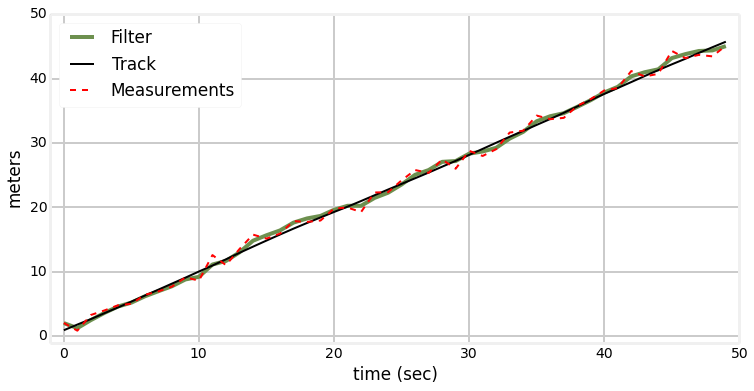

In [42]:
R = 1
Q = 0.03

xs, zs = simulate_system(Q=Q, count=50)

kf = FirstOrderKF(R, Q, dt=1)
fxs1, ps1 = filter_data(kf, zs)

plt.figure()
plot_kf_output(xs, fxs1, zs)

In [43]:
def plot_residuals(xs, filter_xs, Ps, title, y_label):
    res = xs - filter_xs
    plt.plot(res)
    bp.plot_residual_limits(Ps)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel('time (sec)')
    
    plt.show()

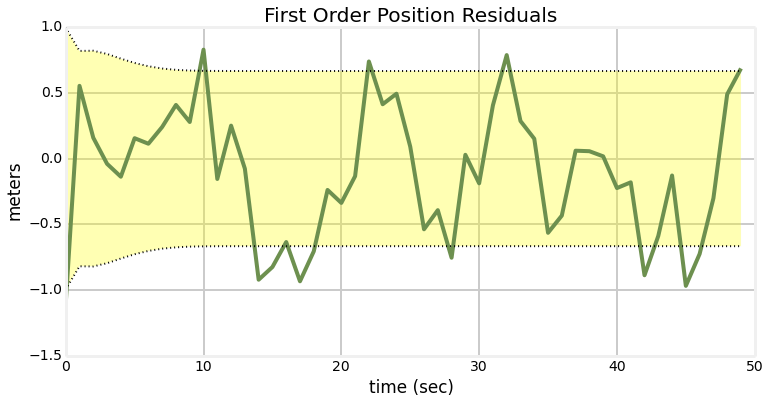

In [44]:
plot_residuals(xs[:,0], fxs1[:,0], ps1[:,0], 
               'First Order Position Residuals',
               'meters')   

* If there was no measurement noise and the Kalman filter prediction was always perfect the residual would always be zero. So the ideal output would be a horizontal line at 0. 
* The residual is centered around 0, so this gives us confidence that the noise is Gaussian (because the errors fall equally above and below 0). 
* The yellow area between dotted lines show the theoretical performance of the filter for 1 standard deviations. In other words, approximately 68% of the errors should fall within the dotted lines. The residual falls within this range, so we see that the filter is performing well.

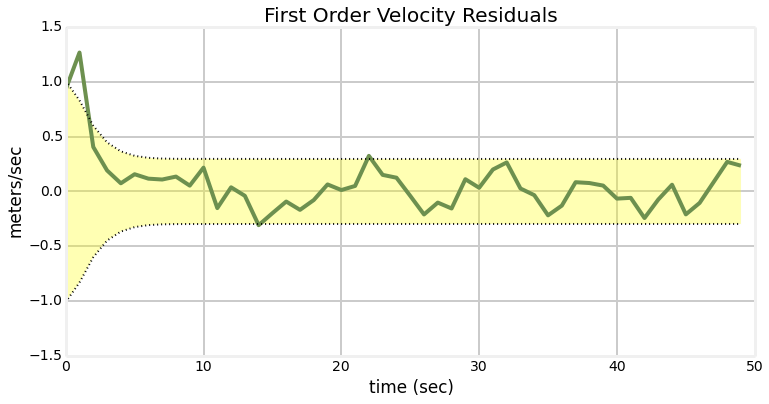

In [45]:
plot_residuals(xs[:,1], fxs1[:,1], ps1[:,1], 
               'First Order Velocity Residuals',
               'meters/sec')   

* The residual falls within the theoretical performance of the filter, so we feel confident that the filter is well designed for this system.

Do the same thing using the zero order Kalman filter.

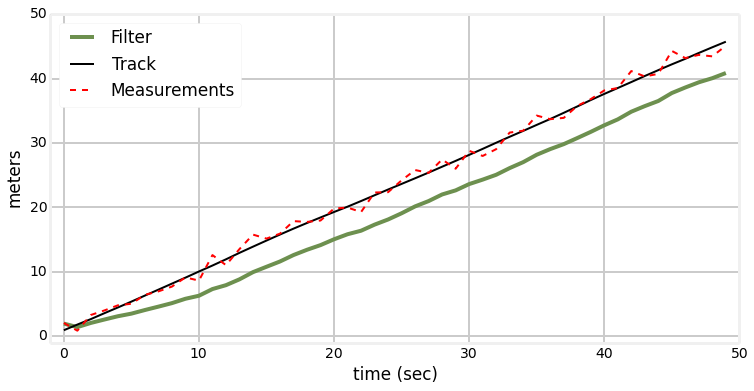

In [46]:
kf0 = ZeroOrderKF(R, Q)
fxs0, ps0 = filter_data(kf0, zs)

plot_kf_output(xs, fxs0, zs)

* The filter lags the input because there were not enough terms to allow the filter to adjust quickly enough to the changes in velocity. 
        On every `predict()` step the Kalman filter assumes that there is no change in position - if the current position is 4.3 it will predict that the position at the next time period is 4.3. Of course, the actual position is closer to 5.3. The measurement, with noise, might be 5.4, so the filter chooses an estimate part way between 4.3 and 5.4, causing it to lag the actual value of 5.3 by a significant amount. This same thing happens in the next step, the next one, and so on. The filter never catches up.


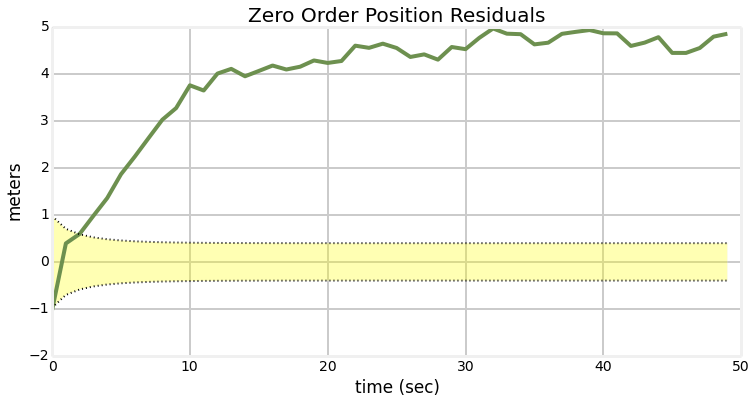

In [47]:
plot_residuals(xs[:,0], fxs0[:,0], ps0[:,0], 
               'Zero Order Position Residuals',
               'meters')

* The filter diverges almost immediately.
* The covariance matrix $\mathbf{P}$ is only reporting the *theoretical* performance of the filter *assuming* all of the inputs are correct. The filter has no way to know that you are lying to it about the system.

* In this system the divergence is immediate and striking. In many systems it will only be gradual, and/or slight. It is important to look at charts like these for your systems to ensure that the performance of the filter is within the bounds of its theoretical performance.

Now let's try a second order system.

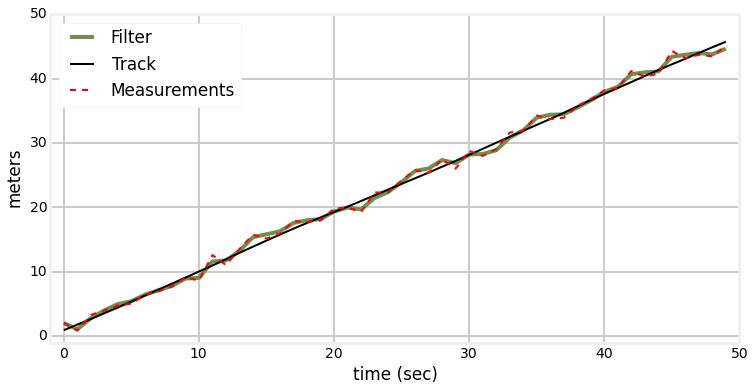

In [48]:
kf2 = SecondOrderKF(R, Q, dt=1)
fxs2, ps2 = filter_data(kf2, zs)

plot_kf_output(xs, fxs2, zs)

* The second order filter performs poorly compared to the first order filter. 
* The system believes that there is acceleration in the system, and so the large changes in the measurement gets interpreted as acceleration instead of noise. 
        The filter tracks the noise in the system quite closely. Not only that, but it *overshoots* the noise in places if the noise is consistently above or below the track because the filter incorrectly assumes an acceleration that does not exist, and so it's prediction goes further and further away from the track on each measurement.

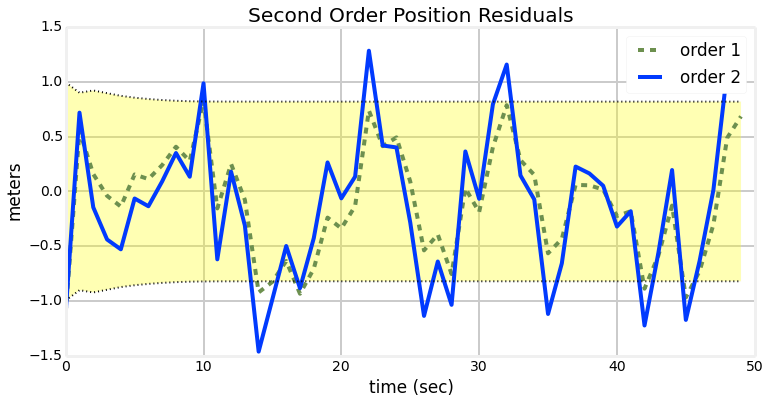

In [49]:
res = xs[:,0] - fxs2[:,0]
res1 = xs[:,0] - fxs1[:,0]

plt.plot(res1, ls="--", label='order 1')
plt.plot(res, label='order 2')
bp.plot_residual_limits(ps2[:,0])
plt.title('Second Order Position Residuals')
plt.legend()
plt.ylabel('meters')
plt.xlabel('time (sec)')
plt.show()

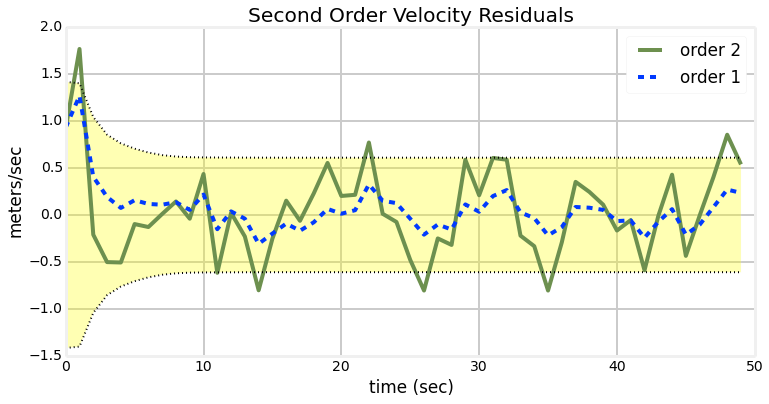

In [50]:
res = xs[:,1] - fxs2[:,1]
res1 = xs[:,1] - fxs1[:,1]
plt.plot(res, label='order 2')
plt.plot(res1, ls='--', label='order 1')
bp.plot_residual_limits(ps2[:,1])
plt.title('Second Order Velocity Residuals')
plt.legend()
plt.ylabel('meters/sec')
plt.xlabel('time (sec)')
plt.show()

* For the residuals of the position, the second order is slight worse, but the difference is not large. There is nothing very alarming here.
* For the residuals of the velocity, the residuals of the second order filter are *far* worse than for the first order filter

* A lower order filter can track a higher order process so long as you add enough process noise. 
* The results will not be optimal, but they can still be good.

First, the simulation of a second order process.

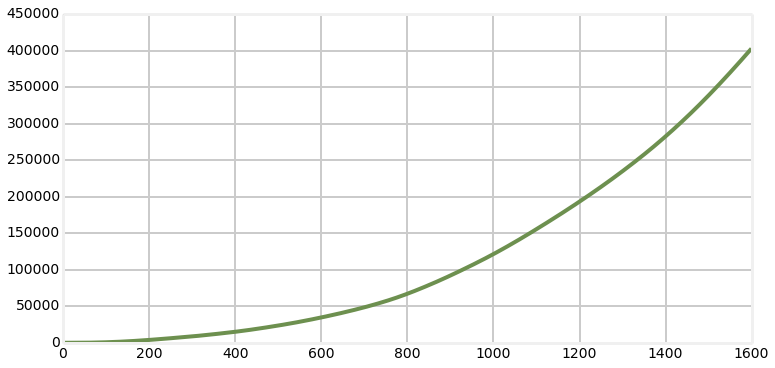

In [51]:
class ConstantAccelerationObject(object):
    def __init__(self, x0=0, vel=1., acc=0.1, acc_noise_scale=.1):
        self.x = x0
        self.vel = vel
        self.acc = acc
        self.acc_noise_scale = acc_noise_scale
    
    def update(self):
        self.acc += randn()*self.acc_noise_scale       
        self.vel += self.acc
        self.x += self.vel
        return (self.x, self.vel, self.acc)

   
R = 6.
Q = 0.02
def simulate_acc_system(R, Q, count):
    obj = ConstantAccelerationObject(acc_noise_scale=Q)
    zs = []
    xs = []
    for i in range(count):
        x = obj.update()
        z = sense(x, R)
        xs.append(x)
        zs.append(z)
    return np.asarray(xs), zs

np.random.seed(124)
xs,zs = simulate_acc_system(R=R, Q=Q, count=1600)
plt.plot(xs[:,0])
plt.show()

Now filter the data using a second order filter. 

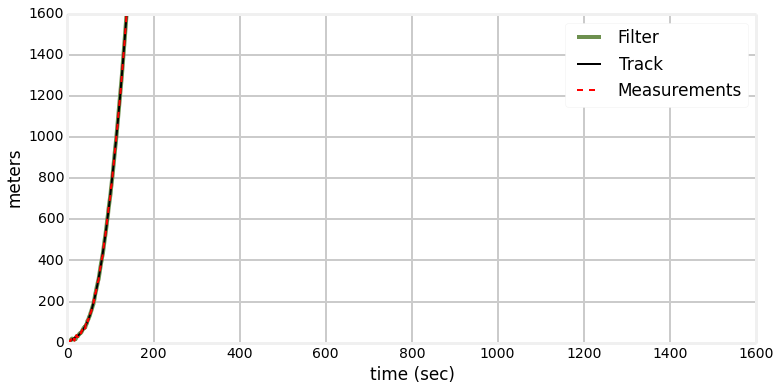

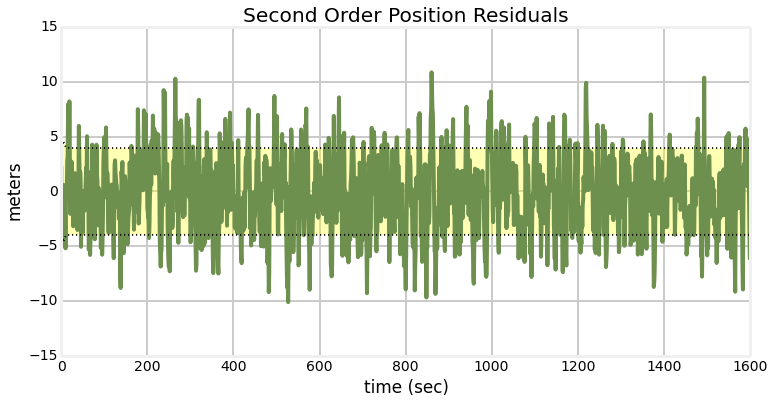

In [52]:
kf2 = SecondOrderKF(R, Q, dt=1)
fxs2, ps2 = filter_data(kf2, zs)

plot_kf_output(xs, fxs2, zs)
plot_residuals(xs[:,0], fxs2[:,0], ps2[:,0], 
               'Second Order Position Residuals',
               'meters') 

* The filter is performing within the theoretical limits of the filter. 

* Now let's use a lower order filter.

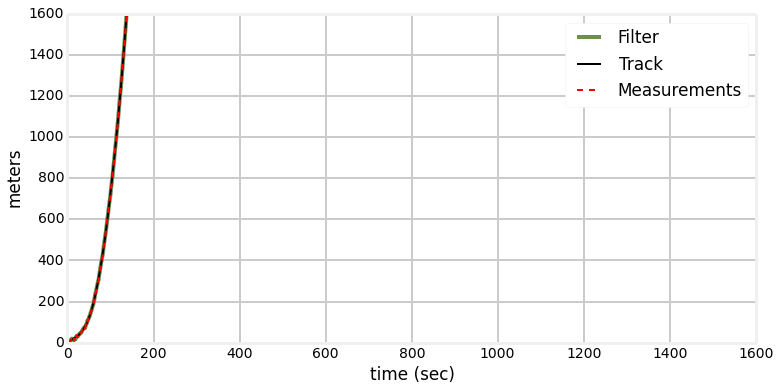

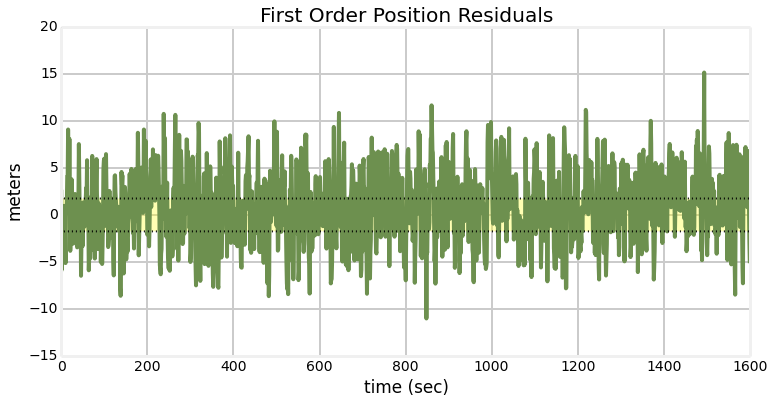

In [53]:
kf1 = FirstOrderKF(R, Q*20, dt=1)
fxs1, ps1 = filter_data(kf1, zs)

plot_kf_output(xs, fxs1, zs)
plot_residuals(xs[:,0], fxs1[:,0], ps1[:,0], 
               'First Order Position Residuals',
               'meters') 

* The lower order filter will lag the signal because it is not modeling the acceleration.
* We can account for that (to an extent) by increasing the size of the process noise. 
        The filter will treat the acceleration as noise in the process model. The result will be suboptimal, but if designed well it will not diverge. Choosing the amount of extra process noise is not an exact science. You will have to experiment with representative data.

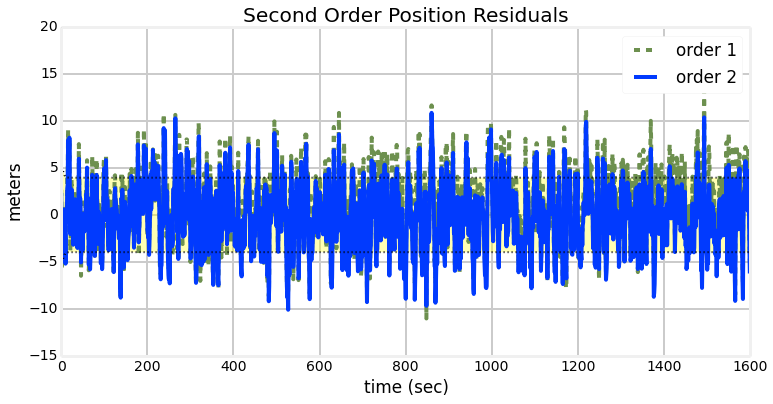

In [54]:
res = xs[:,0] - fxs2[:,0]
res1 = xs[:,0] - fxs1[:,0]

plt.plot(res1, ls="--", label='order 1')
plt.plot(res, label='order 2')
bp.plot_residual_limits(ps2[:,0])
plt.title('Second Order Position Residuals')
plt.legend()
plt.ylabel('meters')
plt.xlabel('time (sec)')
plt.show()

## Sensor Fusion

* Consider a situation where we have two sensors measuring the same value at each time.
* Suppose a vehicle in 1D World, such as a train on a railway. 
* It has a sensor attached to the wheels counting revolutions, which can be converted to a distance along the track, and a GPS-like sensor, called a 'PS', which reports position. Thus, we have two measurements, both reporting position along the track. So the measurement vector is a vector of the measurements from the wheel and the PS.

$$ \mathbf{Z} = \begin{bmatrix}z_{wheel} \\ z_{ps}\end{bmatrix}$$

* Suppose that we decide that our Kalman filter state should contain the position and velocity of the train, so that

$$ \mathbf{X} = \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

* The matrix $\mathbf{H}$ to convert $\mathbf{X}$ to $\mathbf{Z}$ :

$$ \begin{bmatrix}z_{wheel} \\ z_{ps}\end{bmatrix} = \begin{bmatrix}1 &0 \\ 1& 0\end{bmatrix} \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

To make it clearer, suppose that the wheel reports not position but the number of rotations of the wheels, where 1 revolution yields 2m of travel. In that case we would write

$$ \begin{bmatrix}z_{wheel} \\ z_{ps}\end{bmatrix} = \begin{bmatrix}0.5 &0 \\ 1& 0\end{bmatrix} \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

* Design the measurement noise matrix $\mathbf{R}$. Suppose that the measurement variance for the PS is twice the variance of the wheel, and the standard deviation of the wheel is 1.5m

$$\sigma_{wheel} =  1.5\\
\sigma^2_{wheel} = 2.25 \\ 
\sigma_{ps} = 1.5*2 = 3 \\
\sigma^2_{ps} = 9.
$$

* Design for Q, but that is invariant to whether we are doing sensor fusion or not, so choose some arbitrary value for Q.

* Assume a velocity of 10m/s with an update rate of 0.1 seconds.

fusion std: 0.391


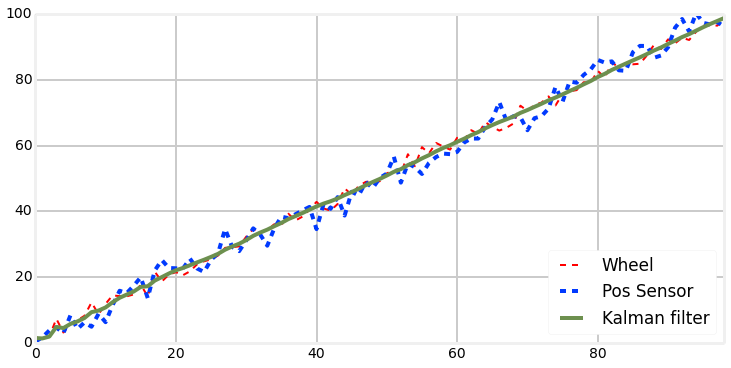

In [55]:
import numpy.random as random
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
from numpy import array, asarray

def fusion_test(wheel_sigma, ps_sigma, do_plot=True):
    dt = 0.1
    kf = KalmanFilter(dim_x=2, dim_z=2)

    kf.F = array([[1., dt], [0., 1.]])
    kf.H = array([[1., 0.], [1., 0.]])
    kf.x = array([[0.], [1.]])
    kf.Q *= array([[(dt**3)/3, (dt**2)/2],
                   [(dt**2)/2,  dt      ]]) * 0.02
    kf.P *= 100
    kf.R[0,0] = wheel_sigma**2
    kf.R[1,1] = ps_sigma**2 

    random.seed(1123)
    xs = []
    zs = []
    nom = []
    for i in range(1, 100):
        m0 = i + randn()*wheel_sigma
        m1 = i + randn()*ps_sigma
        z = array([[m0], [m1]])

        kf.predict()
        kf.update(z)

        xs.append(kf.x.T[0])
        zs.append(z.T[0])
        nom.append(i)

    xs = asarray(xs)
    zs = asarray(zs)
    nom = asarray(nom)


    res = nom-xs[:,0]
    print('fusion std: {:.3f}'.format (np.std(res)))
    if do_plot:
        bp.plot_measurements(zs[:,0], label='Wheel')
        plt.plot(zs[:,1], linestyle='--', label='Pos Sensor')
        bp.plot_filter(xs[:,0], label='Kalman filter')
        plt.legend(loc=4)
        plt.ylim(0,100)
        plt.show()

fusion_test(1.5, 3.0)

### Prove that the PS improves the filter

* Force the Kalman filter to disregard the PS measurement by setting the measurement noise for the PS to a near infinite value.

In [56]:
fusion_test(1.5, 1e80, do_plot=False)

fusion std: 0.438


* Write a Kalman filter that only takes one measurement.

std: 0.523


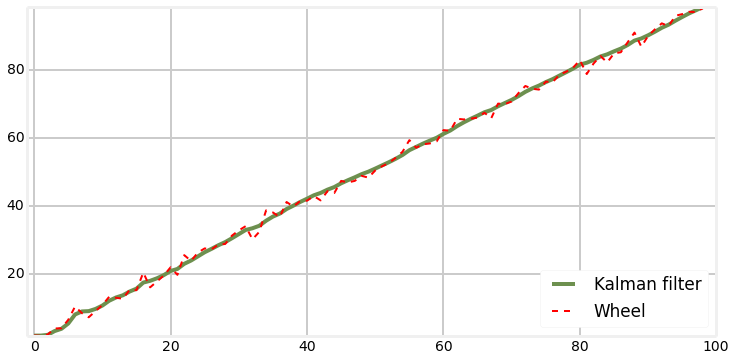

In [57]:
import numpy.random as random
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
from numpy import array, asarray

dt = 0.1
wheel_sigma = 1.5
kf = KalmanFilter(dim_x=2, dim_z=1)

kf.F = array ([[1., dt], [0., 1.]])
kf.H = array ([[1., 0.]])
kf.x = array ([[0.], [1.]])
kf.Q *= 0.01
kf.P *= 100
kf.R[0,0] = wheel_sigma**2

random.seed(1123)
xs = []
zs = []
nom = []
for i in range(1, 100):
    m0 = i + randn()*wheel_sigma
    z = array([[m0]])

    kf.predict()
    kf.update(z)

    xs.append(kf.x.T[0])
    zs.append(z.T[0])
    nom.append(i)

xs = asarray(xs)
zs = asarray(zs)
nom = asarray(nom)


res = nom-xs[:,0]
print('std: {:.3f}'.format (np.std(res)))

bp.plot_filter(xs[:,0], label='Kalman filter')
bp.plot_measurements(zs[:,0],label='Wheel')
plt.legend(loc=4)
plt.xlim((-1,100))
plt.show()

We got a standard deviation of 0.523 vs the value of 0.391 for the fused measurements. 

### Different Data Rates

* Two different sensor classes often output data at different rates. 
* Assume that the PS produces an update at 1 Hz, and the wheel updates at 4 Hz. 

* We can do this by setting the data rate to 0.25 seconds, which is 4 Hz. As we loop, on every iteration we call `update()` with only the wheel measurement. Then, every fourth time we will call `update()` with both the wheel and PS measurements. 

    * Vary the amount of data in the z parameter.
* The matrices associated with the measurement are $\mathbf{H}$ and $\mathbf{R}$
    * When only the wheel reading is available, set
$$\mathbf{H} = \begin{bmatrix}1 &0\end{bmatrix}.$$

$$\mathbf{R} = \begin{bmatrix}\sigma_{wheel}^2\end{bmatrix}$$

* The two matrices that incorporate time are $\mathbf{F}$ and $\mathbf{Q}$. For example,

$$\mathbf{F} = \begin{bmatrix}1 & \Delta t \\ 0& 1\end{bmatrix}.$$
* Set $\delta t =0.25$ and not modify it while filtering. 
    If the readings did not coincide in each iteration you would have to calculate how much time has passed since the last predict, compute a new $\mathbf{F}$ and $\mathbf{Q}$, and then call `predict()` so the filter could make a correct prediction based on the time step required.

fusion std: 0.452


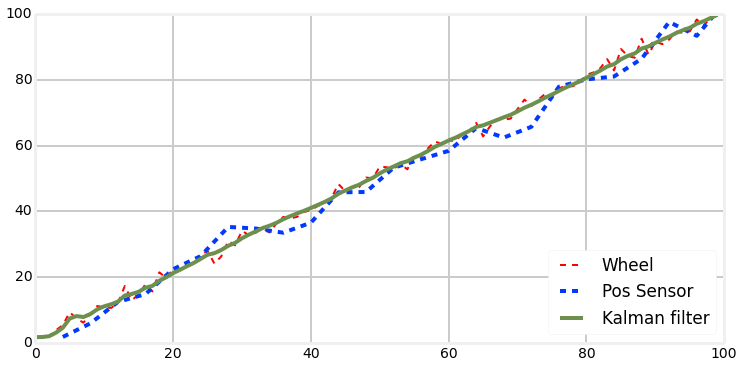

In [58]:
import numpy.random as random
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
from numpy import array, asarray

def fusion_test(wheel_sigma, ps_sigma, do_plot=True):
    dt = 0.25
    kf = KalmanFilter(dim_x=2, dim_z=2)

    kf.F = array([[1., dt], [0., 1.]])
    kf.H = array([[1., 0.], [1., 0.]])
    kf.x = array([[0.], [1.]])
    kf.Q *= array([[(dt**3)/3, (dt**2)/2],
                   [(dt**2)/2,  dt      ]]) * 0.02
    kf.P *= 100
    kf.R[0,0] = wheel_sigma**2
    kf.R[1,1] = ps_sigma**2 

    random.seed(1123)
    xs = []
    zs_wheel = []
    zs_ps = []
    nom = []
    for i in range(1, 101):
        
        if i % 4 == 0:
            m0 = i + randn()*wheel_sigma
            m1 = i + randn()*ps_sigma
            z = array([[m0], [m1]])
            kf.H = array([[1., 0.], [1., 0.]])
            R = np.eye(2)
            R[0,0] = wheel_sigma**2
            R[1,1] = ps_sigma**2      
            
            zs_wheel.append(m0)
            zs_ps.append((i,m1))
        else:  
            m0 = i + randn()*wheel_sigma
            z = array([m0])
            kf.H = array([[1., 0.]])
            R = np.eye(1) * wheel_sigma**2
            zs_wheel.append(m0)

        kf.predict()
        kf.update(z, R)

        xs.append(kf.x.T[0])
        nom.append(i)

    xs = asarray(xs)
    nom = asarray(nom)

    res = nom-xs[:,0]
    print('fusion std: {:.3f}'.format (np.std(res)))
    if do_plot:
        bp.plot_measurements(zs_wheel,  label='Wheel')
        plt.plot(*zip(*zs_ps), linestyle='--', label='Pos Sensor')
        bp.plot_filter(xs[:,0], label='Kalman filter')
        plt.legend(loc=4)
        plt.ylim(0,100)
        plt.show()

fusion_test(1.5, 3.0)

From the standard deviation that the performance is a bit worse than when the PS and wheel were measured in every update, but better than the wheel alone.

## Tracking a Ball

* In a constant gravitational field A ball thrown in a vacuum will travel in a parabola. 

$$
\begin{aligned}
y &= \frac{g}{2}t^2 + v_{y0} t + y_0 \\
x &= v_{x0} t + x_0
\end{aligned}
$$

where $g$ is the gravitational constant, $t$ is time, $v_{x0}$ and $v_{y0}$ are the initial velocities in the x and y plane. 

* If the ball is thrown with an initial velocity of $v$ at angle $\theta$ above the horizon, we can compute $v_{x0}$ and $v_{y0}$ as

$$
\begin{aligned}
v_{x0} = v \cos{\theta} \\
v_{y0} = v \sin{\theta}
\end{aligned}
$$

In [59]:
from math import radians, sin, cos
import math

def rk4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply to 
      compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

def fx(x,t):
    return fx.vel
    
def fy(y,t):
    return fy.vel - 9.8*t


class BallTrajectory2D(object):
    def __init__(self, x0, y0, velocity, 
                 theta_deg=0., 
                 g=9.8, 
                 noise=[0.0,0.0]):
        self.x = x0
        self.y = y0
        self.t = 0
        
        theta = math.radians(theta_deg)

        fx.vel = math.cos(theta) * velocity
        fy.vel = math.sin(theta) * velocity
        
        self.g = g
        self.noise = noise
        
        
    def step(self, dt):
        self.x = rk4(self.x, self.t, dt, fx)
        self.y = rk4(self.y, self.t, dt, fy)
        self.t += dt 
        return (self.x + random.randn()*self.noise[0], 
                self.y + random.randn()*self.noise[1])

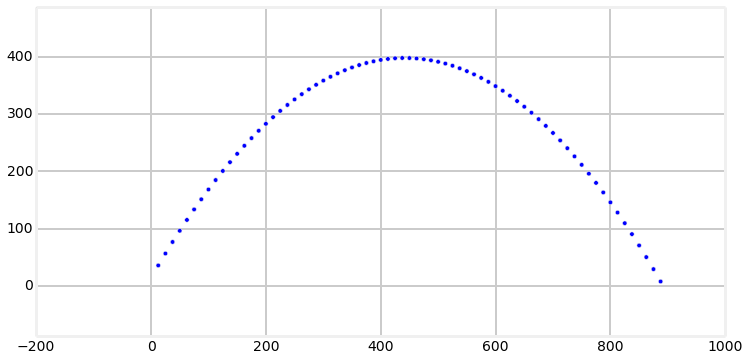

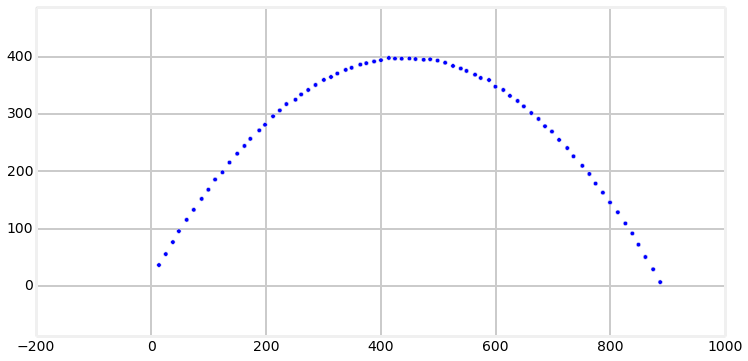

In [60]:
def test_ball_vacuum(noise):
    y = 15
    x = 0
    ball = BallTrajectory2D(x0=x, y0=y, 
                            theta_deg=60., velocity=100., 
                            noise=noise)
    t = 0
    dt = 0.25
    while y >= 0:
        x,y = ball.step(dt)
        t += dt
        if y >= 0:
            plt.scatter(x,y)
         
    plt.axis('equal')
    plt.show()
    
test_ball_vacuum([0,0]) # plot ideal ball position
test_ball_vacuum([1,1]) # plot with noise 

### Step 1: Choose the State Variables

* Use the same state variables as used for tracking the vehicle will not work.
    * Recall that the Kalman filter state transition must be written as $\mathbf{x}' = \mathbf{F x}$, which means we must calculate the current state from the previous state.
    * Our assumption is that the ball is traveling in a vacuum, so the velocity in x is a constant, and the acceleration in y is solely due to the gravitational constant $g$.

* We can discretize the Newtonian equations using the well known Euler method in terms of $\Delta t$ are:

$$\begin{aligned}
x_t &=  x_{t-1} + v_{x_{t-1}} {\Delta t} \\
v_{x_{t}} &= v_{x_{t-1}}
\\
y_t &= -\frac{g}{2} {\Delta t}^2 + v_{y_{t-1}} {\Delta t} + y_{t-1} \\
v_{yt} &= -g {\Delta t} + v_{y(t-1)} \\
\end{aligned}
$$

This suggests the following state variables.

$$
\mathbf{x} = 
\begin{bmatrix}
x \\
\dot{x} \\
y \\
\dot{y} \\
\ddot{y}
\end{bmatrix}
$$

### **Step 2:**  Design State Transition Function

* The state equations for position and velocity would be:

$$
\begin{aligned}
x' &= (1*x) + (\Delta t * v_x) + (0*y) + (0 * v_y) + (0 * a_y) \\
v_x &= (0*x) +  (1*v_x) + (0*y) + (0 * v_y) + (0 * a_y) \\
y' &= (0*x) + (0* v_x)         + (1*y) + (\Delta t * v_y) + (\frac{1}{2}{\Delta t}^2*a_y)  \\
v_y &= (0*x) +  (0*v_x) + (0*y) + (1*v_y) + (\Delta t * a_y) \\
a_y &= (0*x) +  (0*v_x) + (0*y) + (0*v_y) + (1 * a_y) 
\end{aligned}
$$

In matrix form we write this as:

$$
\mathbf{F} = \begin{bmatrix}
1 & \Delta t & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 \\
0 & 0 & 1 & \Delta t & \frac{1}{2}{\Delta t}^2 \\
0 & 0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

* Now test the filter by calling predict until y = 0, which corresponds to the ball hitting the ground.
* Graph the output against the idealized computation of the ball’s position. If the model is correct, the Kalman filter prediction should match the ideal model very closely.

In [ ]:

from math import sin,cos,radians

def ball_kf(x, y, omega, v0, dt):

    g = 9.8 # gravitational constant

    kf = KalmanFilter(dim_x=5, dim_z=2)


    ay = .5*dt**2

    kf.F = np.array([[1, dt,  0,  0,  0],   # x   = x0+dx*dt
                     [0,  1,  0,  0,  0],   # dx  = dx
                     [0,  0,  1, dt, ay],   # y   = y0 +dy*dt+1/2*g*dt^2
                     [0,  0,  0,  1, dt],   # dy  = dy0 + ddy*dt 
                     [0,  0,  0,  0, 1]])   # ddy = -g.
    
    # compute velocity in x and y
    omega = radians(omega)
    vx = cos(omega) * v0
    vy = sin(omega) * v0
    
    kf.Q *= 0.
    kf.x = np.array([[x, vx, y, vy, -g]]).T
    
    return kf

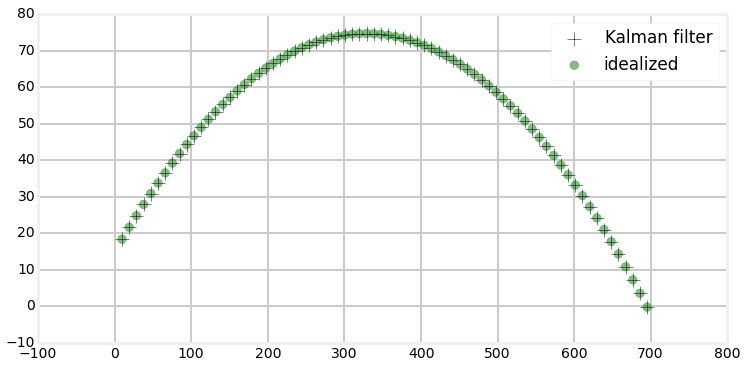

In [62]:
y = 15.
x = 0.
theta = 20. # launch angle
v0 = 100.
dt = 0.1   # time step

ball = BallTrajectory2D(x0=x, y0=y, theta_deg=theta, 
                        velocity=v0, noise=[0,0])
kf = ball_kf(x, y, theta, v0, dt)
t = 0
while kf.x[2, 0] > 0:
    t += dt
    kf.predict() 
    x, y = ball.step(dt)
    p2 = plt.scatter(x, y,                 
                     color='g', marker='o', s=75, 
                     alpha=0.5)
    p1 = plt.scatter(kf.x[0, 0], kf.x[2, 0], 
                     color='k', marker='+', s=200)

plt.legend([p1, p2], ['Kalman filter', 'idealized'], scatterpoints=1)
plt.show()

### **Step 3**: Design the Motion Function

There are no control inputs to the ball flight, set the motion transition function $\small\mathbf{B}=0$.

### **Step 4**: Design the Measurement Function

* Assume that we have a sensor that provides us with the position of the ball in (x,y), but cannot measure velocities or accelerations. 

$$
\begin{bmatrix}z_x \\ z_y \end{bmatrix}= 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0
\end{bmatrix} * 
\begin{bmatrix}
x \\
\dot{x} \\
y \\
\dot{y} \\
\ddot{y}\end{bmatrix}$$

where

$$\mathbf{H} = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0
\end{bmatrix}$$

### **Step 5**: Design the Measurement Noise Matrix

* Assume that the error is independent in $x$ and $y$, and that the measurement error in x and y are 0.5 meters. Hence,

$$\mathbf{R} = \begin{bmatrix}0.5&0\\0&0.5\end{bmatrix}$$

### Step 6: Design the Process Noise Matrix

Assuming a ball moving in a vacuum, there should be no process
noise. We need a $5{\times}5$ covariance matrix for 5 state variables:

$$\mathbf{Q} = \begin{bmatrix}0&0&0&0&0\\0&0&0&0&0\\0&0&0&0&0\\0&0&0&0&0\\0&0&0&0&0\end{bmatrix}$$

In a perfect vacuum our predictions would be perfect, and actually there is no need for a Kalman filter.
We will alter this example to be more realistic by incorporating air drag and ball spin.

### Step 7: Design the Initial Conditions

    omega = radians(omega)
    vx = cos(omega) * v0
    vy = sin(omega) * v0

    f1.x = np.array([[x, vx, y, vy, -g]]).T
    


In [4]:
from math import sin,cos,radians

def ball_kf(x, y, omega, v0, dt, r=0.5, q=0.):

    g = 9.8 # gravitational constant
    kf = KalmanFilter(dim_x=5, dim_z=2)

    ay = .5*dt**2
    kf.F = np.array ([[1, dt,  0,  0,  0],   # x   = x0+dx*dt
                      [0,  1,  0,  0,  0],   # dx  = dx
                      [0,  0,  1, dt, ay],   # y   = y0 +dy*dt+1/2*g*dt^2
                      [0,  0,  0,  1, dt],   # dy  = dy0 + ddy*dt 
                      [0,  0,  0,  0, 1]])   # ddy = -g.

    kf.H = np.array([[1, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0]])
    
    kf.R *= r
    kf.Q *= q

    omega = radians(omega)
    vx = cos(omega) * v0
    vy = sin(omega) * v0

    kf.x = np.array([[x, vx, y, vy, -9.8]]).T
    
    return kf

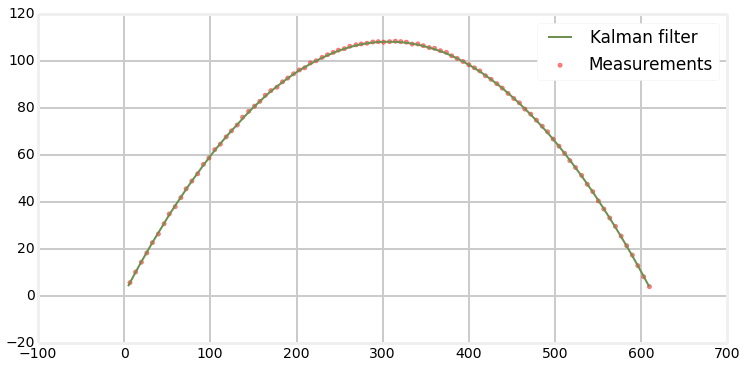

In [64]:
y = 1.
x = 0.
theta = 35. # launch angle
v0 = 80.
dt = 1/10.   # time step

ball = BallTrajectory2D(x0=x, y0=y, theta_deg=theta, velocity=v0, 
                        noise=[.2,.2])
kf = ball_kf(x,y,theta,v0,dt)

t = 0
xs = []
ys = []
while kf.x[2,0] > 0:
    t += dt
    x,y = ball.step(dt)
    z = np.array([[x, y]]).T

    kf.update(z)
    xs.append(kf.x[0,0])
    ys.append(kf.x[2,0])
    
    kf.predict() 
    
    p1 = plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)

p2, = plt.plot (xs, ys,lw=2)
plt.legend([p2, p1], ['Kalman filter', 'Measurements'], scatterpoints=1)
plt.show()

## Tracking a Ball in Air

* Assume that we are tracking a ball traveling through the Earth's atmosphere. The path of the ball is influenced by wind, drag, and the rotation of the ball. 
* Assume that our sensor is a camera; code that we will not implement will perform some type of image processing to detect the position of the ball. 
* We will not assume that we know the starting position, angle, or rotation of the ball; the tracking code will have to initiate tracking based on the measurements that are provided. 

* The main simplification that we are making here is a 2D world; we assume that the ball is always traveling orthogonal to the plane of the camera's sensor. 

### Implementing Air Drag

A ball moving through air encounters wind resistance. This imparts a force on the ball, called *drag*, which alters the flight of the ball, developed by Nicholas Giordano and Hisao Nakanishi in Computational Physics, 1997, denoted as

$$F_{drag} = -B_2v^2$$

where $B_2$ is a coefficient derived experimentally, and $v$ is the velocity of the object. $F_{drag}$ can be factored into $x$ and $y$ components with

$$F_{drag,x} = -B_2v v_x\\
F_{drag,y} = -B_2v v_y
$$

If $m$ is the mass of the ball, we can use $F=ma$ to compute the acceleration as

$$ a_x = -\frac{B_2}{m}v v_x\\
a_y = -\frac{B_2}{m}v v_y$$

Giordano provides the following function for $\frac{B_2}{m}$, which takes air density, the cross section of a baseball, and its roughness into account. Understand that this is an approximation based on wind tunnel tests and several simplifying assumptions. It is in SI units: velocity is in meters/sec and time is in seconds.

$$\frac{B_2}{m} = 0.0039 + \frac{0.0058}{1+\exp{[(v-35)/5]}}$$

Starting with this Euler discretization of the ball path in a vacuum:
$$\begin{aligned}
x &= v_x \Delta t \\
y &= v_y \Delta t \\
v_x &= v_x \\
v_y &= v_y - 9.8 \Delta t
\end{aligned}
$$

We can incorporate this force (acceleration) into our equations by incorporating $accel * \Delta t$ into the velocity update equations. We should subtract this component because drag will reduce the velocity. The code to do this is quite straightforward, we just need to break out the Force into $x$ and $y$ components. 

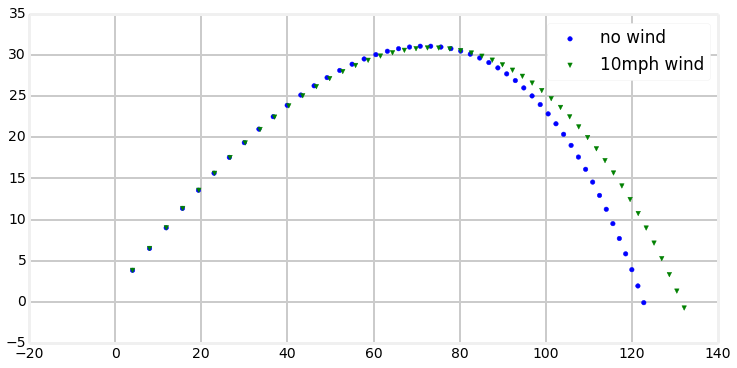

In [65]:
from math import sqrt, exp, cos, sin, radians

def mph_to_mps(x):
    return x * .447

def drag_force(velocity):
    """ Returns the force on a baseball due to air drag at
    the specified velocity. Units are SI"""

    return (0.0039 + 0.0058 / (1. + exp((velocity-35.)/5.))) * velocity

v = mph_to_mps(110.)
y = 1
x = 0
dt = .1
theta = radians(35)

def solve(x, y, vel, v_wind, launch_angle):
    xs = []
    ys = []
    v_x = vel*cos(launch_angle)
    v_y = vel*sin(launch_angle)
    while y >= 0:
        # Euler equations for x and y
        x += v_x*dt
        y += v_y*dt

        # force due to air drag    
        velocity = sqrt ((v_x-v_wind)**2 + v_y**2)    
        F = drag_force(velocity)

        # euler's equations for vx and vy
        v_x = v_x - F*(v_x-v_wind)*dt
        v_y = v_y - 9.8*dt - F*v_y*dt
        
        xs.append(x)
        ys.append(y)
    
    return xs, ys
        
x,y = solve(x=0, y=1, vel=v, v_wind=0, launch_angle=theta)
p1 = plt.scatter(x, y, color='blue', label='no wind')

x,y = solve(x=0, y=1,vel=v, v_wind=mph_to_mps(10), launch_angle=theta)
p2 = plt.scatter(x, y, color='green', marker="v", label='10mph wind')
plt.legend(scatterpoints=1)
plt.show()

We can easily see the difference between the trajectories in a vacuum and in the air.

In [2]:
from math import radians, sin, cos, sqrt, exp

class BaseballPath(object):
    def __init__(self, x0, y0, launch_angle_deg, velocity_ms, 
                 noise=(1.0,1.0)): 
        """ Create 2D baseball path object  
           (x = distance from start point in ground plane, 
            y=height above ground)
        
        x0,y0            initial position
        launch_angle_deg angle ball is travelling respective to 
                         ground plane
        velocity_ms      speeed of ball in meters/second
        noise            amount of noise to add to each position
                         in (x,y)
        """
        
        omega = radians(launch_angle_deg)
        self.v_x = velocity_ms * cos(omega)
        self.v_y = velocity_ms * sin(omega)

        self.x = x0
        self.y = y0

        self.noise = noise


    def drag_force(self, velocity):
        """ Returns the force on a baseball due to air drag at
        the specified velocity. Units are SI
        """
        B_m = 0.0039 + 0.0058 / (1. + exp((velocity-35.)/5.))
        return B_m * velocity


    def update(self, dt, vel_wind=0.):
        """ compute the ball position based on the specified time 
        step and wind velocity. Returns (x,y) position tuple.
        """

        # Euler equations for x and y
        self.x += self.v_x*dt
        self.y += self.v_y*dt

        # force due to air drag
        v_x_wind = self.v_x - vel_wind
        v = sqrt(v_x_wind**2 + self.v_y**2)
        F = self.drag_force(v)

        # Euler's equations for velocity
        self.v_x = self.v_x - F*v_x_wind*dt
        self.v_y = self.v_y - 9.81*dt - F*self.v_y*dt

        return (self.x + random.randn()*self.noise[0], 
                self.y + random.randn()*self.noise[1])

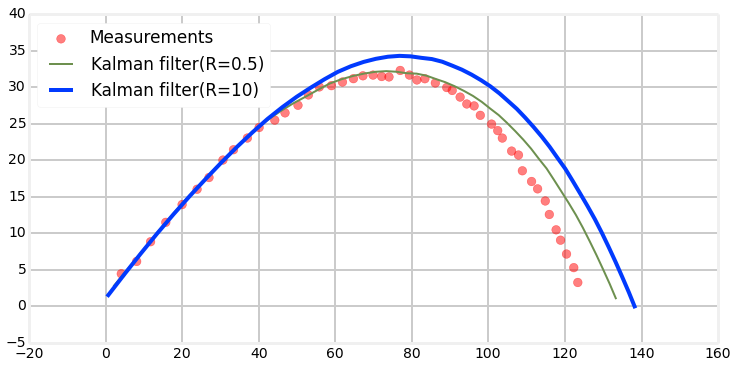

In [9]:
y = 1.
x = 0.
theta = 35. # launch angle
v0 = 50.
dt = 1/10.   # time step

ball = BaseballPath(x0=x, y0=y, launch_angle_deg=theta,
                    velocity_ms=v0, noise=[.3,.3])
f1 = ball_kf(x,y,theta,v0,dt,r=1.)
f2 = ball_kf(x,y,theta,v0,dt,r=10.)
t = 0
xs = []
ys = []
xs2 = []
ys2 = []

while f1.x[2,0] > 0:
    t += dt
    x,y = ball.update(dt)
    z = np.array([[x, y]]).T

    f1.update(z)
    f2.update(z)
    xs.append(f1.x[0,0])
    ys.append(f1.x[2,0])
    xs2.append(f2.x[0,0])
    ys2.append(f2.x[2,0])    
    f1.predict() 
    f2.predict()
    
    p1 = plt.scatter(x, y, color='r', marker='o', s=75, alpha=0.5)

p2, = plt.plot (xs, ys, lw=2)
p3, = plt.plot (xs2, ys2, lw=4)
plt.legend([p1,p2, p3], 
           ['Measurements', 'Kalman filter(R=0.5)', 'Kalman filter(R=10)'],
           loc='best', scatterpoints=1)
plt.show()

At first both track the measurements well, but as time continues they both diverge. This happens because the state model for air drag is nonlinear and the Kalman filter assumes that it is linear.



The following code implements the same Kalman filter as before, but with a non-zero process noise.
* Plot two examples, one with Q=.1, and one with Q=0.01.

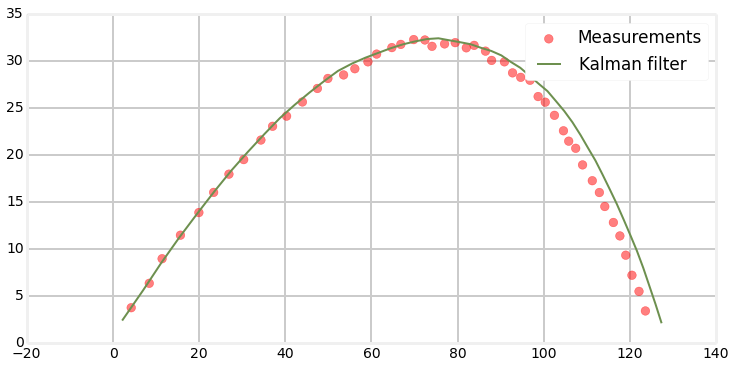

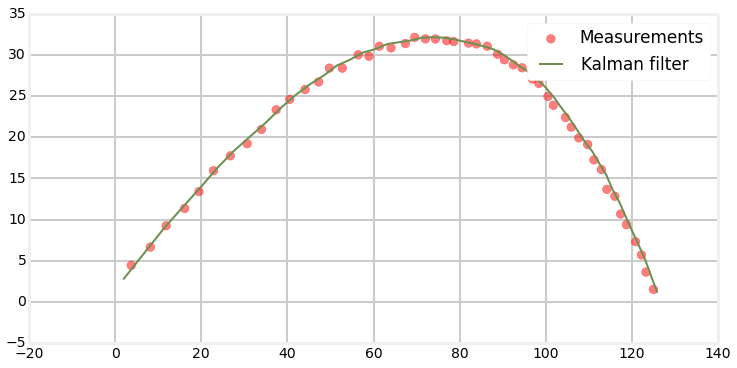

In [10]:
def plot_ball_with_q(q, r=1., noise=0.3):
    y = 1.
    x = 0.
    theta = 35. # launch angle
    v0 = 50.
    dt = 1/10.   # time step

    ball = BaseballPath(x0=x, 
                        y0=y, 
                        launch_angle_deg=theta, 
                        velocity_ms=v0, 
                        noise=[noise,noise])
    f1 = ball_kf(x,y,theta,v0,dt,r=r, q=q)
    t = 0
    xs = []
    ys = []

    while f1.x[2,0] > 0:
        t += dt
        x,y = ball.update(dt)
        z = np.array([[x,y]]).T

        f1.update(z)
        xs.append(f1.x[0,0])
        ys.append(f1.x[2,0]) 
        f1.predict() 


        p1 = plt.scatter(x, y, color='r', marker='o', s=75, alpha=0.5)

    p2, = plt.plot (xs, ys,lw=2)
    plt.legend([p1, p2], ['Measurements', 'Kalman filter'], scatterpoints=1)
    plt.show()
    
plot_ball_with_q(0.01)
plot_ball_with_q(0.1)

* The second filter tracks the measurements fairly well. 
* Is this a good technique? 
    * It depends. Here the nonlinearity of the force on the ball is fairly constant and regular.
    * Consider this next plot with increased the noise in the measurements.

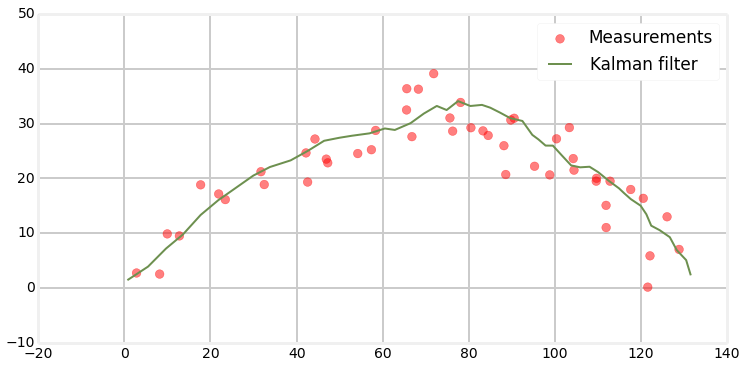

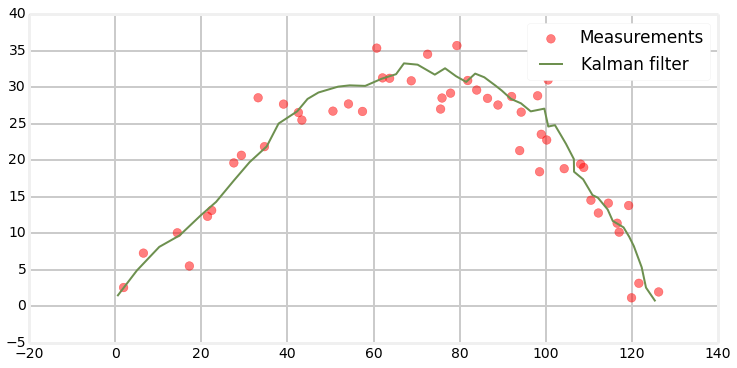

In [69]:
plot_ball_with_q(0.01, r=3, noise=3.)
plot_ball_with_q(0.1, r=3, noise=3.)

This output is terrible. The filter has no choice but to give more weight to the measurements than the process (prediction step), but when the measurements are noisy the filter output will just track the noise. This inherent limitation of the linear Kalman filter is what lead to the development of nonlinear versions of the filter.